In [1]:
import numpy as np
from glob import glob
import os
import mne 
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import main

In [3]:
def read_data(file_path):
    data = mne.io.read_raw_edf(file_path, preload=True) #preload is faster but consumes more memory
    data.set_eeg_reference()
    data.filter(l_freq=0.5, h_freq=45) #usual band for eeg 
    epochs = mne.make_fixed_length_epochs(data, duration=5,overlap=1)
    array = epochs.get_data()

    return array

In [4]:
def shuffle_group_labels(groups):
    # Ensure the input groups are integers and extract the unique groups
    unique_groups = np.unique(groups)
    
    # Shuffle the unique group labels
    shuffled_groups = np.random.permutation(unique_groups)
    
    # Create a mapping from original group labels to shuffled labels
    group_mapping = dict(zip(unique_groups, shuffled_groups))
    
    # Remap the original group labels to shuffled labels
    shuffled_group_labels = np.vectorize(group_mapping.get)(groups)
    
    return shuffled_group_labels

## Read the Data

In [81]:
# Load the environment variables from the .env file
main.load_dotenv()

# Access the variable
dataset_path = os.getenv('DATASET_PATH')

# Use the variable in your code

In [6]:
files_paths = glob(dataset_path + f"/*.edf")

In [7]:
print(len(files_paths))

28


In [8]:
healthy_files_paths = [i for i in files_paths if 'h' in i.split('\\')[-1]]
sch_files_paths = [i for i in files_paths if 's' in i.split('\\')[-1]]

In [82]:
%%capture
sample_data = read_data(healthy_files_paths[0])

In [10]:
sample_data.shape #Number of epochs, number of channels, length of signal 

#EEG epoching is a procedure in which specific time-windows are extracted from the continuous EEG signal.
# These time windows are called “epochs”, and usually are time-locked with respect an event e.g. a visual stimulus 

(231, 19, 1250)

## Convert the data into features and labelled arrays

In [11]:
%%capture
healthy_epochs_arrays = [ read_data(i) for i in healthy_files_paths]
sch_epochs_arrays = [ read_data(i) for i in sch_files_paths]

In [12]:
healthy_epochs_labels = [len(i)*[0] for i in healthy_epochs_arrays]
sch_epochs_labels = [len(i)*[1] for i in sch_epochs_arrays]

In [13]:
#interleave the data so that each datapoint is alternated between one healthy and one patient, even is healthy and odd is patient
data_list = []
label_list = []

for i in range(len(sch_epochs_arrays)):
    data_list.append(healthy_epochs_arrays[i])
    data_list.append(sch_epochs_arrays[i])

    label_list.append(healthy_epochs_labels[i])
    label_list.append(sch_epochs_labels[i])

In [11]:
#data_list = healthy_epochs_arrays + sch_epochs_arrays
#label_list = healthy_epochs_labels + sch_epochs_labels

In [14]:
# to avoid data leakage of multiple arrays from the same patient to be split into training and testing
# we will group the data so that its categorized for each patient which will will be considered in the splitting later
grouped_list = [[i]*len(j) for i,j in enumerate(data_list)]

## ML CLassification

In [34]:
data_array = np.vstack(data_list)
labels_array = np.hstack(label_list)
groups_array = np.hstack(grouped_list)
print(data_array.shape,labels_array.shape,groups_array.shape)

(7201, 19, 1250) (7201,) (7201,)


its 7201 rows because there are 28 patients (14 sch and 14 healthy), which average 257 epochs, so the whole data list would have 257*28

### Feature Extraction

each feature has shape 7201,19

In [35]:
from scipy import stats
def mean(data):
    return np.mean(data,axis=-1)
    
def std(data):
    return np.std(data,axis=-1)

def ptp(data):
    return np.ptp(data,axis=-1) #maximum - minimum (range of values)

def var(data):
        return np.var(data,axis=-1)

def minim(data):
      return np.min(data,axis=-1)


def maxim(data):
      return np.max(data,axis=-1)

def argminim(data):
      return np.argmin(data,axis=-1)

def argmaxim(data):
      return np.argmax(data,axis=-1)

def mean_square(data):
      return np.mean(data**2,axis=-1)

def rms(data): #root mean square
    return  np.sqrt(np.mean(data**2,axis=-1))  

def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=-1)),axis=-1)

def skewness(data):
    return stats.skew(data,axis=-1)

def kurtosis(data):
    return stats.kurtosis(data,axis=-1)

def concatenate_features(data):
    return np.concatenate((mean(data),std(data),ptp(data),var(data),minim(data),maxim(data),argminim(data),argmaxim(data),
                          mean_square(data),rms(data),abs_diffs_signal(data),
                          skewness(data),kurtosis(data)),axis=-1)

In [36]:
features = []

for d in data_array:
    features.append(concatenate_features(d))

In [37]:
features_array = np.array(features)
features_array.shape   # so we have 13 features per channel, and we have 19 channels, thats why its 7201x247

(7201, 247)

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold,GridSearchCV,cross_val_score,cross_validate 

#### Logistic Regression

In [64]:
clf=LogisticRegression(max_iter=1000)
gkf=GroupKFold(n_splits=5)
param_grid = {'classifier__C': [0.1,0.3,0.5,0.7,1,3]}
pipe=Pipeline([('scaler',StandardScaler()),('classifier',clf)])
gscv=GridSearchCV(pipe,param_grid,cv=gkf)
gscv.fit(features,labels_array,groups=groups_array)

GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'classifier__C': [0.1, 0.3, 0.5, 0.7, 1, 3]})

In [65]:
gscv.best_score_

0.6682048732862116

#### Random Forest

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

rdm=RandomForestClassifier()
gkf=GroupKFold(n_splits=5)
param_grid = {'classifier__n_estimators': [10,50,100,200]}
pipe=Pipeline([('scaler',StandardScaler()),('classifier',rdm)])
pipeline_rf=GridSearchCV(pipe,param_grid,cv=gkf)
# Random Forest pipeline
pipeline_rf.fit(features, labels_array, groups=groups_array)

GridSearchCV(cv=GroupKFold(n_splits=5),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier())]),
             param_grid={'classifier__n_estimators': [10, 50, 100, 200]})

In [70]:
pipeline_rf.best_score_

0.6462555216552026

## 1D-CNN

first, we check that we have the gpu running

In [15]:
one_d_cnn_data_array=np.vstack(data_list)
one_d_cnn_label_array=np.hstack(label_list)
one_d_cnn_group_array=np.hstack(grouped_list)

print(one_d_cnn_data_array.shape,one_d_cnn_label_array.shape,one_d_cnn_group_array.shape)

(7201, 19, 1250) (7201,) (7201,)


In [16]:
one_d_cnn_data_array=np.moveaxis(one_d_cnn_data_array,1,2) #cnn in keras expects the input channels at the end
print(one_d_cnn_data_array.shape)

(7201, 1250, 19)


In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D,BatchNormalization,LeakyReLU,MaxPool1D,\
GlobalAveragePooling1D,Dense,Dropout,AveragePooling1D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from tensorflow.keras import backend as K


from sklearn.model_selection import GroupKFold,LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random


#### Initial CNN

In [36]:
def cnnmodel():
    clear_session()
    model=Sequential()
    
    model.add(Conv1D(filters=5,kernel_size=3,strides=1,input_shape=(one_d_cnn_data_array.shape[1],one_d_cnn_data_array.shape[2])))#1
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(MaxPool1D(pool_size=2,strides=2))#2

    
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#3
    model.add(LeakyReLU())
    model.add(MaxPool1D(pool_size=2,strides=2))#4
    model.add(Dropout(0.5))

    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#5
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2,strides=2))#6
    model.add(Dropout(0.5))
    
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#7
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2,strides=2))#8
    
    model.add(Conv1D(filters=5,kernel_size=3,strides=1))#9
    model.add(LeakyReLU())
    model.add(GlobalAveragePooling1D())#10
    
    model.add(Dense(1,activation='sigmoid'))#11
    
    model.compile('adam',loss='binary_crossentropy',metrics=['accuracy'])
    return model

model=cnnmodel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1248, 5)           290       
                                                                 
 batch_normalization (Batch  (None, 1248, 5)           20        
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1248, 5)           0         
                                                                 
 max_pooling1d (MaxPooling1  (None, 624, 5)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 622, 5)            80        
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 622, 5)            0

In [65]:

gkf=GroupKFold()

In [93]:
  # Importing Keras backend (TensorFlow) for clear_session()

# Initialize lists to store metrics for each fold
accuracies = []
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []
confusion_matrices = []


for train_index, val_index in gkf.split(one_d_cnn_data_array, one_d_cnn_label_array, groups=one_d_cnn_group_array):
    train_features,train_labels=one_d_cnn_data_array[train_index],one_d_cnn_label_array[train_index]
    val_features,val_labels=one_d_cnn_data_array[val_index],one_d_cnn_label_array[val_index]
    
    scaler=StandardScaler()

    train_features = scaler.fit_transform(train_features.reshape(-1, train_features.shape[-1])).reshape(train_features.shape)
    val_features = scaler.transform(val_features.reshape(-1, val_features.shape[-1])).reshape(val_features.shape)
    
    K.clear_session()
    model=cnnmodel()
    
    history = model.fit(train_features,train_labels,
              epochs=10,
              batch_size=128,
              validation_data=(val_features,val_labels)
             )
    
    # Append loss and accuracy from the training history
    training_losses.append(history.history['loss'])
    validation_losses.append(history.history['val_loss'])
    training_accuracies.append(history.history['accuracy'])
    validation_accuracies.append(history.history['val_accuracy'])

    # Generate and store confusion matrix for the fold
    raw_predictions = model.predict(val_features)
    predictions = (raw_predictions > 0.5).astype(int)
    cm = confusion_matrix(val_labels, predictions)

    confusion_matrices.append(cm)

Epoch 1/10
45/45 [==============================] - 5s 60ms/step - loss: 0.6796 - accuracy: 0.5703 - val_loss: 0.7298 - val_accuracy: 0.3720
Epoch 2/10
45/45 [==============================] - 2s 53ms/step - loss: 0.6634 - accuracy: 0.5933 - val_loss: 0.6924 - val_accuracy: 0.3720
Epoch 3/10
45/45 [==============================] - 3s 56ms/step - loss: 0.6503 - accuracy: 0.5935 - val_loss: 0.6527 - val_accuracy: 0.3734
Epoch 4/10
45/45 [==============================] - 2s 53ms/step - loss: 0.6320 - accuracy: 0.6065 - val_loss: 0.6059 - val_accuracy: 0.7186
Epoch 5/10
45/45 [==============================] - 2s 53ms/step - loss: 0.6077 - accuracy: 0.6515 - val_loss: 0.5474 - val_accuracy: 0.8792
Epoch 6/10
45/45 [==============================] - 2s 53ms/step - loss: 0.5671 - accuracy: 0.7296 - val_loss: 0.4698 - val_accuracy: 0.8970
Epoch 7/10
45/45 [==============================] - 2s 53ms/step - loss: 0.4991 - accuracy: 0.7907 - val_loss: 0.3935 - val_accuracy: 0.8916
Epoch 8/10
45

In [94]:
mean_training_losses = np.mean(training_losses,axis=0)
mean_validation_losses = np.mean(validation_losses,axis=0)
mean_training_accuracies = np.mean(training_accuracies,axis=0)
mean_validation_accuracies = np.mean(validation_accuracies,axis=0)

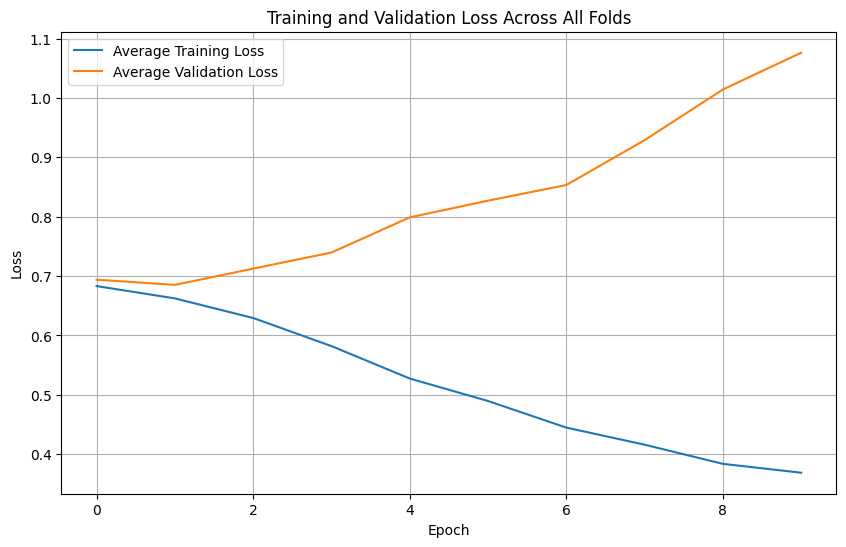

In [95]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(mean_training_losses, label='Average Training Loss')
plt.plot(mean_validation_losses, label='Average Validation Loss')
plt.title('Training and Validation Loss Across All Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

very clear overfitting

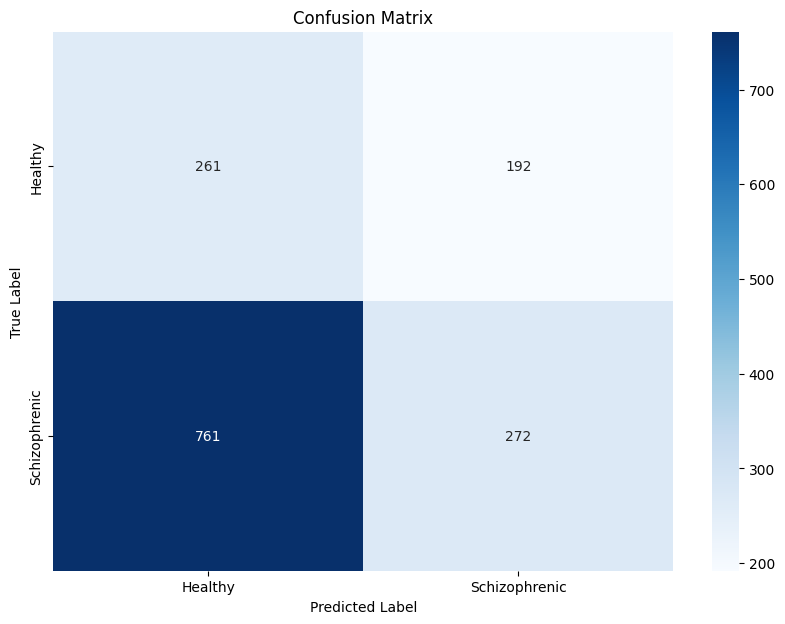

In [110]:
# Plotting the confusion matrix for each fold
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Schizophrenic'], yticklabels=['Healthy', 'Schizophrenic'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### Optimizing CNN

In [73]:
def cnnmodel():
    K.clear_session()
    model=Sequential()
    
    model.add(Conv1D(filters=10,kernel_size=8,strides=2,input_shape=(one_d_cnn_data_array.shape[1],one_d_cnn_data_array.shape[2])))#1
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=2,strides=2))#2
    model.add(Dropout(0.35))

    model.add(Conv1D(filters=5,kernel_size=5,strides=1))#9
    model.add(LeakyReLU())
    model.add(AveragePooling1D(pool_size=3,strides=1))#2
    #model.add(GlobalAveragePooling1D())#10

    model.add(Flatten())

    
    model.add(Dense(128, activation='leaky_relu'))  # Additional Dense layer
    model.add(Dropout(0.4))  # Dropout to prevent overfitting
    model.add(Dense(32, activation='leaky_relu'))  # Additional Dense layer

    
    model.add(Dense(1,activation='sigmoid'))#11

    
    optimizer = Adam(learning_rate=0.0005)  # You can modify the learning rate here

    model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    return model

model=cnnmodel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 622, 10)           1530      
                                                                 
 batch_normalization (Batch  (None, 622, 10)           40        
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 622, 10)           0         
                                                                 
 average_pooling1d (Average  (None, 311, 10)           0         
 Pooling1D)                                                      
                                                                 
 dropout (Dropout)           (None, 311, 10)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 307, 5)            2




Test group: [0]
Epoch 1/8
28/28 [==============================] - 3s 73ms/step - loss: 0.7382 - accuracy: 0.5349 - val_loss: 0.7341 - val_accuracy: 0.2814
Epoch 2/8
28/28 [==============================] - 2s 70ms/step - loss: 0.6952 - accuracy: 0.5551 - val_loss: 0.7891 - val_accuracy: 0.0779
Epoch 3/8
28/28 [==============================] - 2s 67ms/step - loss: 0.6787 - accuracy: 0.5614 - val_loss: 0.8015 - val_accuracy: 0.0216
Epoch 4/8
28/28 [==============================] - 2s 72ms/step - loss: 0.6690 - accuracy: 0.5709 - val_loss: 0.8111 - val_accuracy: 0.0087
Epoch 5/8
28/28 [==============================] - 2s 75ms/step - loss: 0.6652 - accuracy: 0.5722 - val_loss: 0.7883 - val_accuracy: 0.0390
Epoch 6/8
28/28 [==============================] - 2s 77ms/step - loss: 0.6600 - accuracy: 0.5779 - val_loss: 0.7937 - val_accuracy: 0.0476
Epoch 7/8
28/28 [==============================] - 2s 70ms/step - loss: 0.6516 - accuracy: 0.5811 - val_loss: 0.7551 - val_accuracy: 0.1429
E

C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


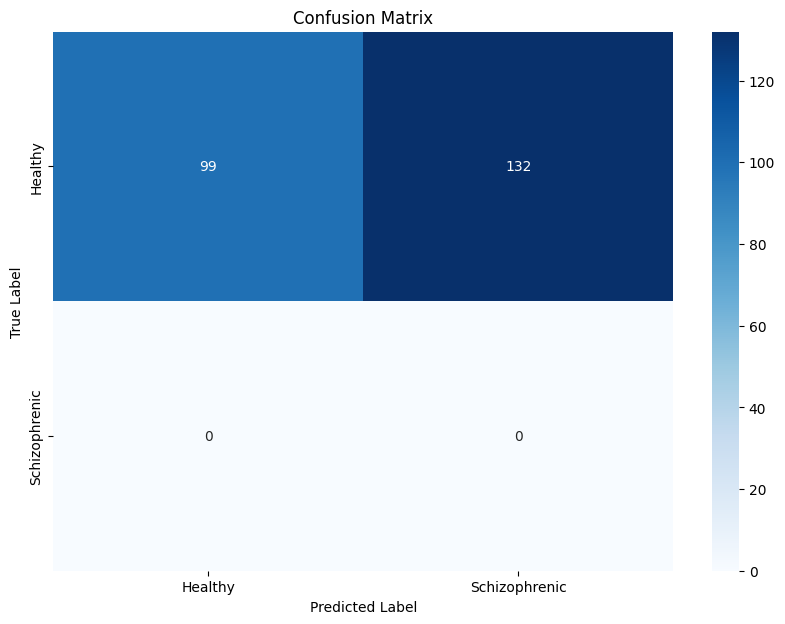




Test group: [1]
Epoch 1/8
28/28 [==============================] - 3s 76ms/step - loss: 0.7267 - accuracy: 0.5453 - val_loss: 0.7898 - val_accuracy: 0.0661
Epoch 2/8
28/28 [==============================] - 2s 81ms/step - loss: 0.6848 - accuracy: 0.5615 - val_loss: 0.8196 - val_accuracy: 0.0044
Epoch 3/8
28/28 [==============================] - 2s 76ms/step - loss: 0.6728 - accuracy: 0.5607 - val_loss: 0.8203 - val_accuracy: 0.0044
Epoch 4/8
28/28 [==============================] - 2s 66ms/step - loss: 0.6714 - accuracy: 0.5621 - val_loss: 0.7981 - val_accuracy: 0.0088
Epoch 5/8
28/28 [==============================] - 2s 65ms/step - loss: 0.6666 - accuracy: 0.5731 - val_loss: 0.8206 - val_accuracy: 0.0000e+00
Epoch 6/8
28/28 [==============================] - 2s 71ms/step - loss: 0.6602 - accuracy: 0.5777 - val_loss: 0.8543 - val_accuracy: 0.0000e+00
Epoch 7/8
28/28 [==============================] - 2s 68ms/step - loss: 0.6563 - accuracy: 0.5716 - val_loss: 0.8184 - val_accuracy: 

C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\li

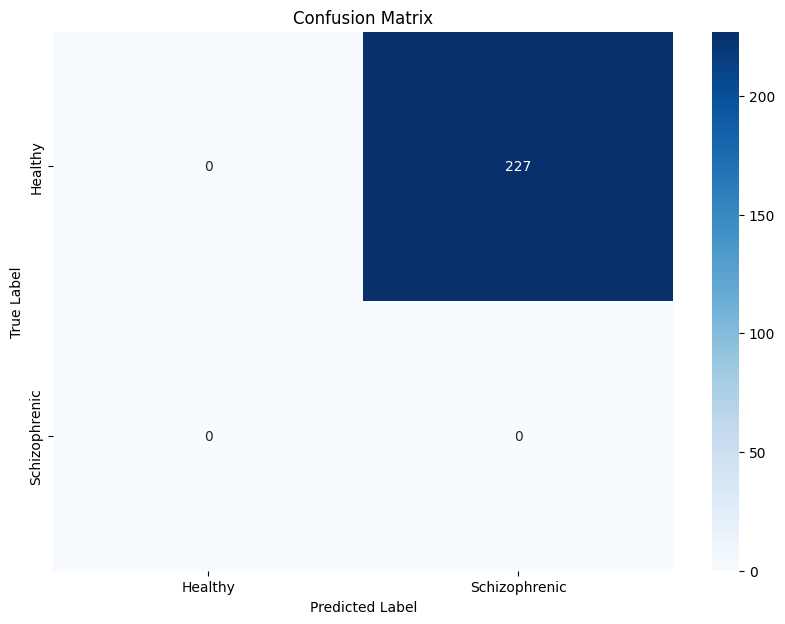




Test group: [2]
Epoch 1/8
28/28 [==============================] - 3s 75ms/step - loss: 0.7157 - accuracy: 0.5353 - val_loss: 0.7147 - val_accuracy: 0.3744
Epoch 2/8
28/28 [==============================] - 2s 67ms/step - loss: 0.6880 - accuracy: 0.5566 - val_loss: 0.7485 - val_accuracy: 0.0485
Epoch 3/8
28/28 [==============================] - 2s 67ms/step - loss: 0.6821 - accuracy: 0.5650 - val_loss: 0.7330 - val_accuracy: 0.1101
Epoch 4/8
28/28 [==============================] - 2s 67ms/step - loss: 0.6773 - accuracy: 0.5578 - val_loss: 0.7329 - val_accuracy: 0.1013
Epoch 5/8
28/28 [==============================] - 2s 75ms/step - loss: 0.6670 - accuracy: 0.5724 - val_loss: 0.7277 - val_accuracy: 0.1498
Epoch 6/8
28/28 [==============================] - 2s 74ms/step - loss: 0.6621 - accuracy: 0.5703 - val_loss: 0.7137 - val_accuracy: 0.3612
Epoch 7/8
28/28 [==============================] - 2s 76ms/step - loss: 0.6549 - accuracy: 0.5810 - val_loss: 0.6793 - val_accuracy: 0.7533
E

C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


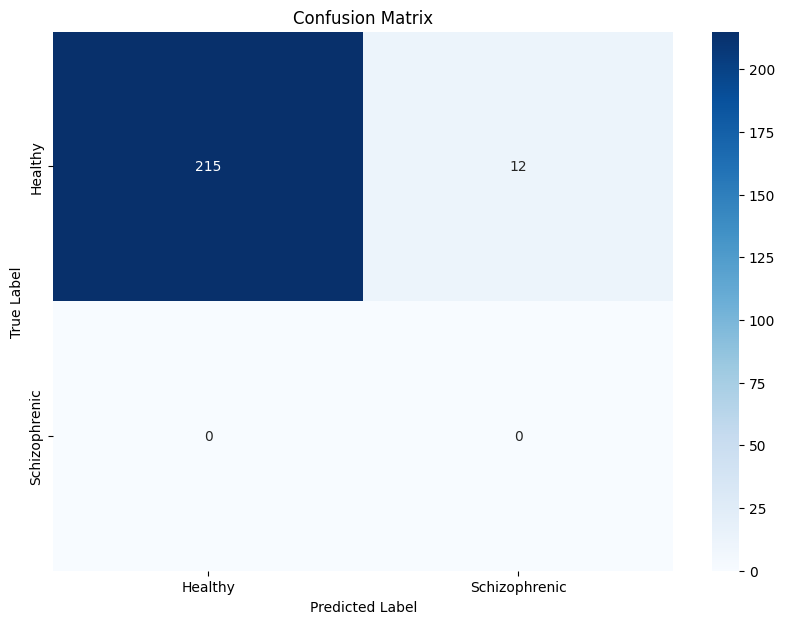




Test group: [3]
Epoch 1/8
28/28 [==============================] - 3s 75ms/step - loss: 0.7401 - accuracy: 0.5324 - val_loss: 0.7853 - val_accuracy: 0.0519
Epoch 2/8
28/28 [==============================] - 2s 67ms/step - loss: 0.6876 - accuracy: 0.5577 - val_loss: 0.7399 - val_accuracy: 0.1082
Epoch 3/8
28/28 [==============================] - 2s 68ms/step - loss: 0.6743 - accuracy: 0.5690 - val_loss: 0.7558 - val_accuracy: 0.0433
Epoch 4/8
28/28 [==============================] - 2s 69ms/step - loss: 0.6615 - accuracy: 0.5819 - val_loss: 0.7512 - val_accuracy: 0.0563
Epoch 5/8
28/28 [==============================] - 2s 72ms/step - loss: 0.6481 - accuracy: 0.5917 - val_loss: 0.7680 - val_accuracy: 0.0476
Epoch 6/8
28/28 [==============================] - 2s 70ms/step - loss: 0.6276 - accuracy: 0.6192 - val_loss: 0.7301 - val_accuracy: 0.2727
Epoch 7/8
28/28 [==============================] - 2s 73ms/step - loss: 0.6059 - accuracy: 0.6542 - val_loss: 0.6984 - val_accuracy: 0.5281
E

C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


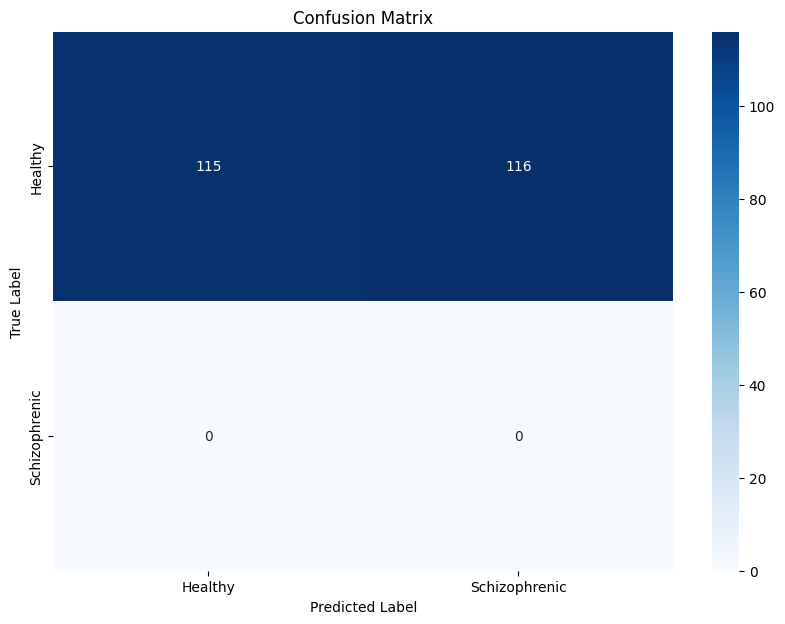




Test group: [4]
Epoch 1/8
28/28 [==============================] - 5s 88ms/step - loss: 0.7149 - accuracy: 0.5457 - val_loss: 0.8725 - val_accuracy: 0.0042
Epoch 2/8
28/28 [==============================] - 2s 71ms/step - loss: 0.6939 - accuracy: 0.5552 - val_loss: 0.8674 - val_accuracy: 0.0042
Epoch 3/8
28/28 [==============================] - 2s 73ms/step - loss: 0.6795 - accuracy: 0.5701 - val_loss: 0.8574 - val_accuracy: 0.0042
Epoch 4/8
28/28 [==============================] - 2s 68ms/step - loss: 0.6752 - accuracy: 0.5627 - val_loss: 0.9125 - val_accuracy: 0.0042
Epoch 5/8
28/28 [==============================] - 2s 72ms/step - loss: 0.6687 - accuracy: 0.5777 - val_loss: 0.8435 - val_accuracy: 0.0042
Epoch 6/8
28/28 [==============================] - 2s 70ms/step - loss: 0.6630 - accuracy: 0.5798 - val_loss: 0.8493 - val_accuracy: 0.0042
Epoch 7/8
28/28 [==============================] - 2s 74ms/step - loss: 0.6524 - accuracy: 0.5940 - val_loss: 0.9005 - val_accuracy: 0.0042
E

C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


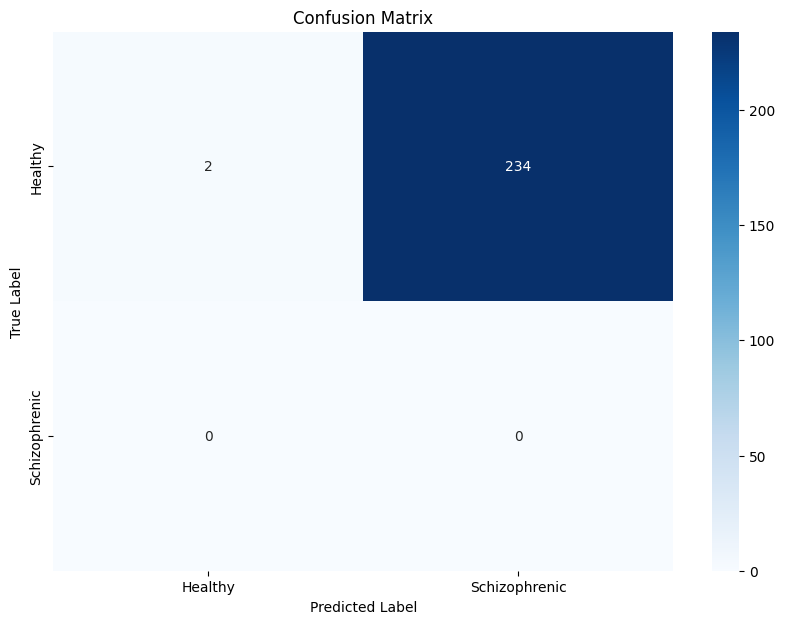




Test group: [5]
Epoch 1/8
28/28 [==============================] - 3s 75ms/step - loss: 0.7142 - accuracy: 0.5413 - val_loss: 0.8032 - val_accuracy: 0.0517
Epoch 2/8
28/28 [==============================] - 2s 71ms/step - loss: 0.6841 - accuracy: 0.5526 - val_loss: 0.7973 - val_accuracy: 0.0129
Epoch 3/8
28/28 [==============================] - 2s 69ms/step - loss: 0.6754 - accuracy: 0.5656 - val_loss: 0.7499 - val_accuracy: 0.0603
Epoch 4/8
28/28 [==============================] - 2s 72ms/step - loss: 0.6686 - accuracy: 0.5682 - val_loss: 0.7411 - val_accuracy: 0.0905
Epoch 5/8
28/28 [==============================] - 2s 70ms/step - loss: 0.6623 - accuracy: 0.5753 - val_loss: 0.7462 - val_accuracy: 0.1379
Epoch 6/8
28/28 [==============================] - 2s 69ms/step - loss: 0.6577 - accuracy: 0.5842 - val_loss: 0.7283 - val_accuracy: 0.2586
Epoch 7/8
28/28 [==============================] - 2s 74ms/step - loss: 0.6475 - accuracy: 0.6041 - val_loss: 0.6998 - val_accuracy: 0.5302
E

C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


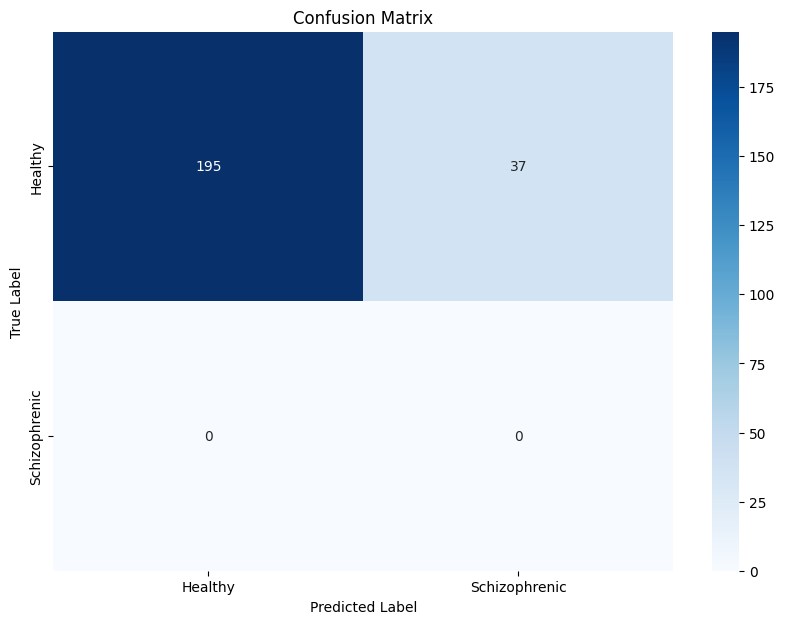




Test group: [6]
Epoch 1/8
28/28 [==============================] - 3s 72ms/step - loss: 0.7162 - accuracy: 0.5377 - val_loss: 0.7360 - val_accuracy: 0.2115
Epoch 2/8
28/28 [==============================] - 2s 72ms/step - loss: 0.6835 - accuracy: 0.5528 - val_loss: 0.7472 - val_accuracy: 0.0793
Epoch 3/8
28/28 [==============================] - 2s 70ms/step - loss: 0.6786 - accuracy: 0.5665 - val_loss: 0.7181 - val_accuracy: 0.2335
Epoch 4/8
28/28 [==============================] - 2s 67ms/step - loss: 0.6687 - accuracy: 0.5650 - val_loss: 0.6996 - val_accuracy: 0.4009
Epoch 5/8
28/28 [==============================] - 2s 71ms/step - loss: 0.6638 - accuracy: 0.5753 - val_loss: 0.6907 - val_accuracy: 0.5639
Epoch 6/8
28/28 [==============================] - 2s 71ms/step - loss: 0.6520 - accuracy: 0.5870 - val_loss: 0.6573 - val_accuracy: 0.8678
Epoch 7/8
28/28 [==============================] - 2s 71ms/step - loss: 0.6328 - accuracy: 0.6233 - val_loss: 0.6010 - val_accuracy: 0.9912
E

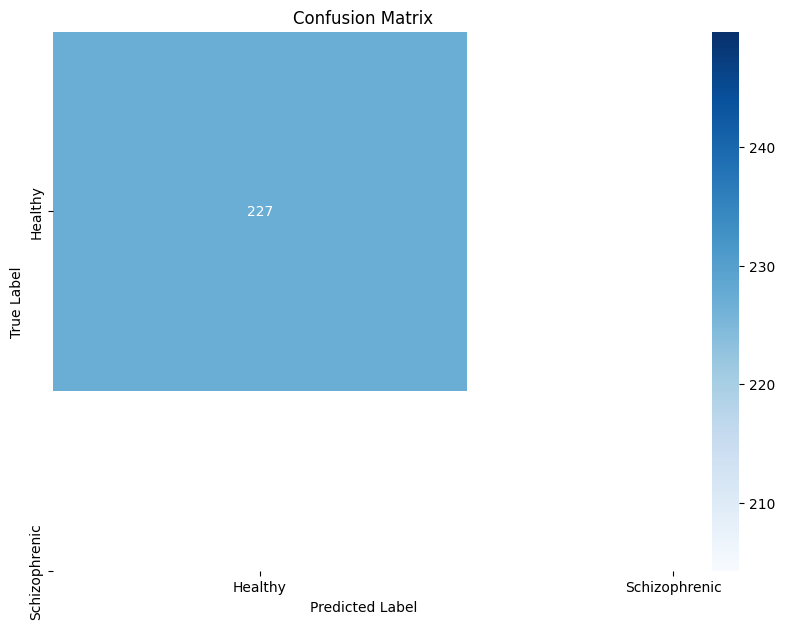




Test group: [7]
Epoch 1/8
28/28 [==============================] - 3s 77ms/step - loss: 0.7340 - accuracy: 0.5321 - val_loss: 0.7201 - val_accuracy: 0.2291
Epoch 2/8
28/28 [==============================] - 2s 72ms/step - loss: 0.6998 - accuracy: 0.5397 - val_loss: 0.7319 - val_accuracy: 0.0881
Epoch 3/8
28/28 [==============================] - 2s 67ms/step - loss: 0.6872 - accuracy: 0.5526 - val_loss: 0.7370 - val_accuracy: 0.0396
Epoch 4/8
28/28 [==============================] - 2s 69ms/step - loss: 0.6881 - accuracy: 0.5576 - val_loss: 0.7327 - val_accuracy: 0.0308
Epoch 5/8
28/28 [==============================] - 2s 68ms/step - loss: 0.6803 - accuracy: 0.5647 - val_loss: 0.7235 - val_accuracy: 0.0485
Epoch 6/8
28/28 [==============================] - 2s 71ms/step - loss: 0.6724 - accuracy: 0.5665 - val_loss: 0.7254 - val_accuracy: 0.0617
Epoch 7/8
28/28 [==============================] - 2s 68ms/step - loss: 0.6723 - accuracy: 0.5700 - val_loss: 0.7391 - val_accuracy: 0.0220
E

C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


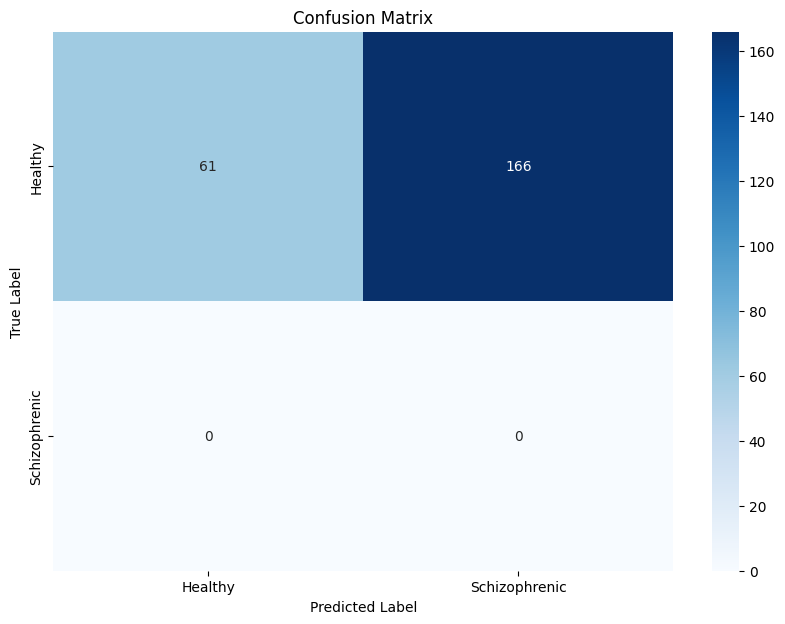




Test group: [8]
Epoch 1/8
28/28 [==============================] - 3s 74ms/step - loss: 0.7169 - accuracy: 0.5428 - val_loss: 0.8526 - val_accuracy: 0.0177
Epoch 2/8
28/28 [==============================] - 2s 68ms/step - loss: 0.6782 - accuracy: 0.5649 - val_loss: 0.7845 - val_accuracy: 0.0575
Epoch 3/8
28/28 [==============================] - 2s 69ms/step - loss: 0.6644 - accuracy: 0.5725 - val_loss: 0.7540 - val_accuracy: 0.1681
Epoch 4/8
28/28 [==============================] - 2s 66ms/step - loss: 0.6562 - accuracy: 0.5913 - val_loss: 0.7638 - val_accuracy: 0.1770
Epoch 5/8
28/28 [==============================] - 2s 66ms/step - loss: 0.6300 - accuracy: 0.6287 - val_loss: 0.7602 - val_accuracy: 0.3496
Epoch 6/8
28/28 [==============================] - 2s 67ms/step - loss: 0.5897 - accuracy: 0.6793 - val_loss: 0.7449 - val_accuracy: 0.5177
Epoch 7/8
28/28 [==============================] - 2s 68ms/step - loss: 0.5376 - accuracy: 0.7309 - val_loss: 0.9353 - val_accuracy: 0.3850
E

C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


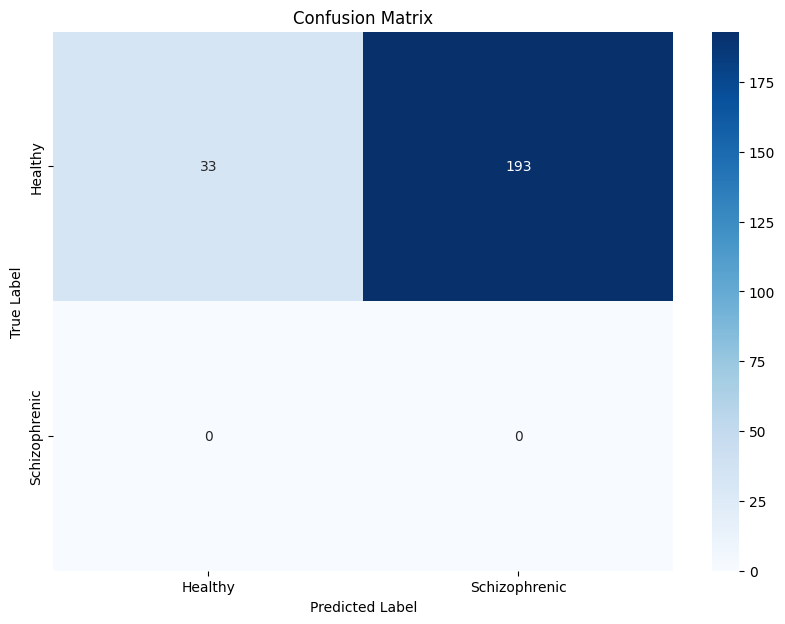




Test group: [9]
Epoch 1/8
28/28 [==============================] - 3s 68ms/step - loss: 0.7453 - accuracy: 0.5373 - val_loss: 0.8086 - val_accuracy: 0.2014
Epoch 2/8
28/28 [==============================] - 2s 67ms/step - loss: 0.6743 - accuracy: 0.5628 - val_loss: 0.8362 - val_accuracy: 0.0899
Epoch 3/8
28/28 [==============================] - 2s 73ms/step - loss: 0.6676 - accuracy: 0.5750 - val_loss: 0.8513 - val_accuracy: 0.0540
Epoch 4/8
28/28 [==============================] - 2s 72ms/step - loss: 0.6601 - accuracy: 0.5755 - val_loss: 0.8417 - val_accuracy: 0.0863
Epoch 5/8
28/28 [==============================] - 2s 70ms/step - loss: 0.6532 - accuracy: 0.5876 - val_loss: 0.8335 - val_accuracy: 0.1727
Epoch 6/8
28/28 [==============================] - 2s 69ms/step - loss: 0.6381 - accuracy: 0.6083 - val_loss: 0.8098 - val_accuracy: 0.3273
Epoch 7/8
28/28 [==============================] - 2s 65ms/step - loss: 0.6128 - accuracy: 0.6434 - val_loss: 0.7685 - val_accuracy: 0.5576
E

C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


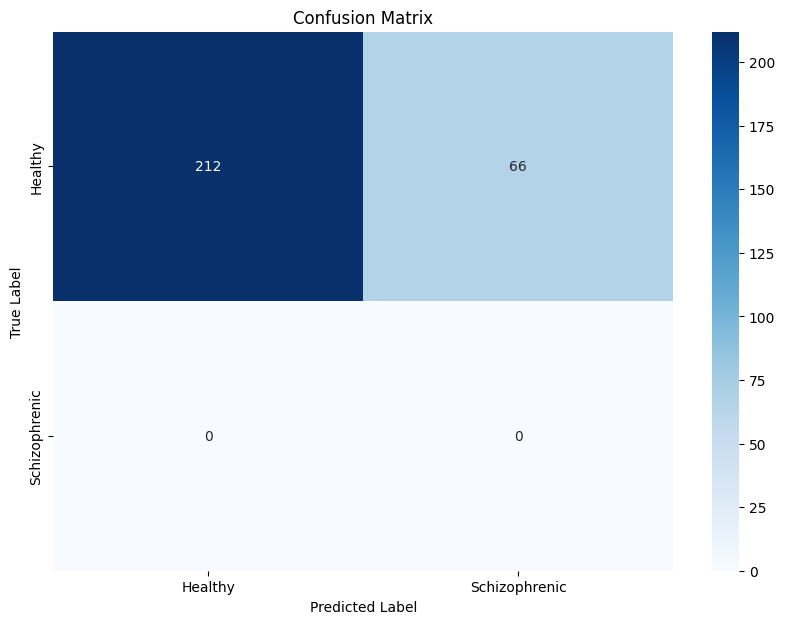




Test group: [10]
Epoch 1/8
28/28 [==============================] - 3s 73ms/step - loss: 0.7707 - accuracy: 0.5325 - val_loss: 0.8912 - val_accuracy: 0.0044
Epoch 2/8
28/28 [==============================] - 2s 64ms/step - loss: 0.6915 - accuracy: 0.5508 - val_loss: 0.8111 - val_accuracy: 0.0088
Epoch 3/8
28/28 [==============================] - 2s 66ms/step - loss: 0.6876 - accuracy: 0.5596 - val_loss: 0.7965 - val_accuracy: 0.0088
Epoch 4/8
28/28 [==============================] - 2s 64ms/step - loss: 0.6754 - accuracy: 0.5643 - val_loss: 0.7961 - val_accuracy: 0.0088
Epoch 5/8
28/28 [==============================] - 2s 67ms/step - loss: 0.6728 - accuracy: 0.5676 - val_loss: 0.7804 - val_accuracy: 0.0088
Epoch 6/8
28/28 [==============================] - 2s 65ms/step - loss: 0.6642 - accuracy: 0.5815 - val_loss: 0.7316 - val_accuracy: 0.2588
Epoch 7/8
28/28 [==============================] - 2s 68ms/step - loss: 0.6561 - accuracy: 0.5785 - val_loss: 0.7342 - val_accuracy: 0.3377


C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


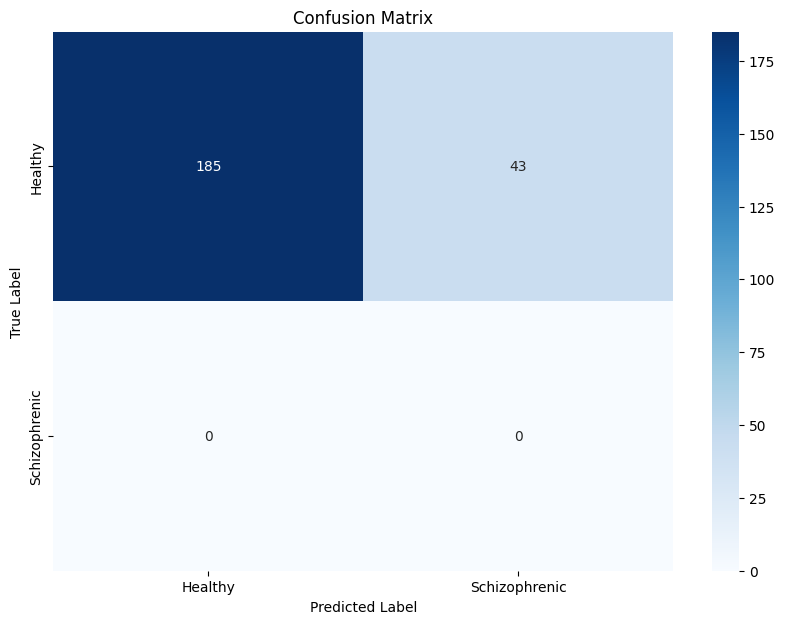




Test group: [11]
Epoch 1/8
28/28 [==============================] - 4s 80ms/step - loss: 0.6996 - accuracy: 0.5464 - val_loss: 0.7884 - val_accuracy: 0.0045
Epoch 2/8
28/28 [==============================] - 2s 68ms/step - loss: 0.6690 - accuracy: 0.5633 - val_loss: 0.8030 - val_accuracy: 0.0000e+00
Epoch 3/8
28/28 [==============================] - 2s 75ms/step - loss: 0.6644 - accuracy: 0.5659 - val_loss: 0.8348 - val_accuracy: 0.0000e+00
Epoch 4/8
28/28 [==============================] - 2s 80ms/step - loss: 0.6565 - accuracy: 0.5712 - val_loss: 0.7995 - val_accuracy: 0.0045
Epoch 5/8
28/28 [==============================] - 2s 77ms/step - loss: 0.6454 - accuracy: 0.5855 - val_loss: 0.8553 - val_accuracy: 0.0000e+00
Epoch 6/8
28/28 [==============================] - 2s 76ms/step - loss: 0.6277 - accuracy: 0.6063 - val_loss: 0.8667 - val_accuracy: 0.0179
Epoch 7/8
28/28 [==============================] - 2s 78ms/step - loss: 0.5898 - accuracy: 0.6688 - val_loss: 1.0217 - val_accur

C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


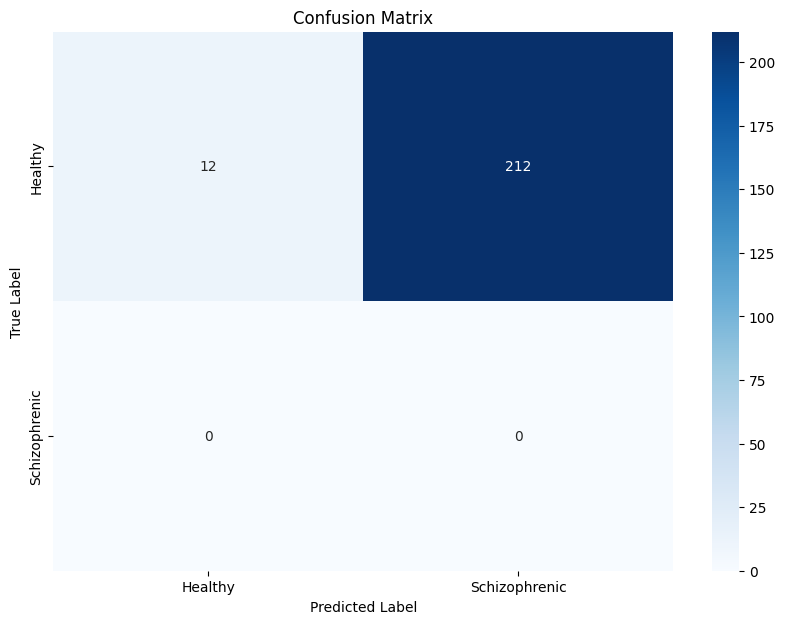




Test group: [12]
Epoch 1/8
28/28 [==============================] - 3s 76ms/step - loss: 0.7351 - accuracy: 0.5296 - val_loss: 0.7458 - val_accuracy: 0.0664
Epoch 2/8
28/28 [==============================] - 2s 68ms/step - loss: 0.6925 - accuracy: 0.5539 - val_loss: 0.7308 - val_accuracy: 0.0705
Epoch 3/8
28/28 [==============================] - 2s 71ms/step - loss: 0.6740 - accuracy: 0.5665 - val_loss: 0.7435 - val_accuracy: 0.0249
Epoch 4/8
28/28 [==============================] - 2s 70ms/step - loss: 0.6753 - accuracy: 0.5681 - val_loss: 0.7373 - val_accuracy: 0.0456
Epoch 5/8
28/28 [==============================] - 2s 72ms/step - loss: 0.6609 - accuracy: 0.5797 - val_loss: 0.7340 - val_accuracy: 0.0622
Epoch 6/8
28/28 [==============================] - 2s 71ms/step - loss: 0.6575 - accuracy: 0.5884 - val_loss: 0.7231 - val_accuracy: 0.1826
Epoch 7/8
28/28 [==============================] - 2s 71ms/step - loss: 0.6395 - accuracy: 0.6138 - val_loss: 0.6990 - val_accuracy: 0.4315


C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


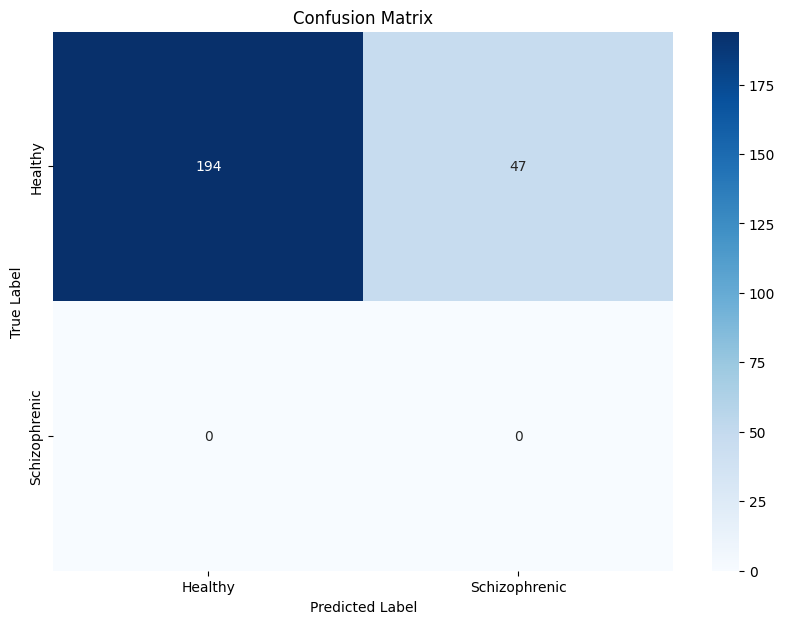




Test group: [13]
Epoch 1/8
28/28 [==============================] - 3s 73ms/step - loss: 0.7190 - accuracy: 0.5363 - val_loss: 0.7951 - val_accuracy: 0.0463
Epoch 2/8
28/28 [==============================] - 2s 68ms/step - loss: 0.6814 - accuracy: 0.5560 - val_loss: 0.7915 - val_accuracy: 0.0139
Epoch 3/8
28/28 [==============================] - 2s 68ms/step - loss: 0.6737 - accuracy: 0.5631 - val_loss: 0.7470 - val_accuracy: 0.0417
Epoch 4/8
28/28 [==============================] - 2s 70ms/step - loss: 0.6700 - accuracy: 0.5585 - val_loss: 0.7596 - val_accuracy: 0.0278
Epoch 5/8
28/28 [==============================] - 2s 67ms/step - loss: 0.6664 - accuracy: 0.5739 - val_loss: 0.7490 - val_accuracy: 0.0324
Epoch 6/8
28/28 [==============================] - 2s 72ms/step - loss: 0.6559 - accuracy: 0.5808 - val_loss: 0.7382 - val_accuracy: 0.0880
Epoch 7/8
28/28 [==============================] - 2s 70ms/step - loss: 0.6521 - accuracy: 0.5821 - val_loss: 0.7144 - val_accuracy: 0.3519


C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


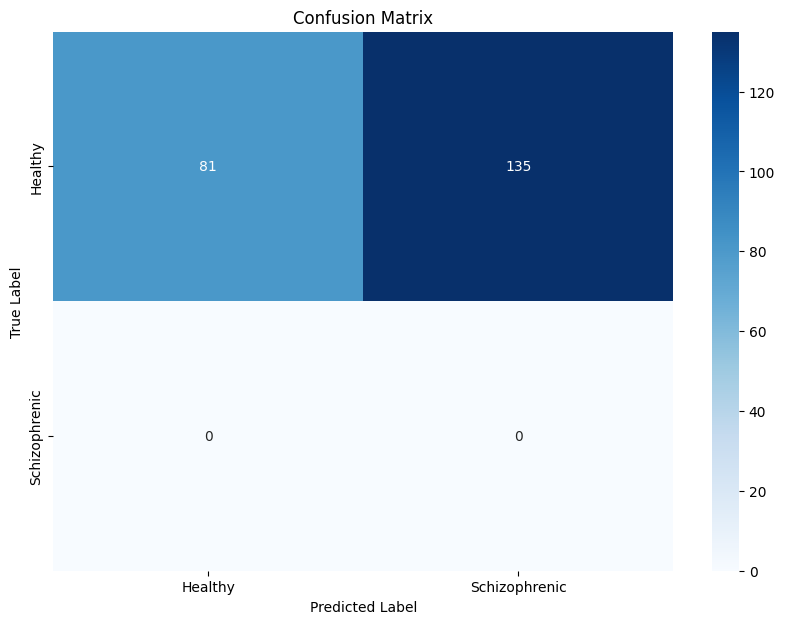




Test group: [14]
Epoch 1/8
28/28 [==============================] - 3s 72ms/step - loss: 0.7412 - accuracy: 0.5089 - val_loss: 0.6337 - val_accuracy: 0.9716
Epoch 2/8
28/28 [==============================] - 2s 66ms/step - loss: 0.6938 - accuracy: 0.5335 - val_loss: 0.6314 - val_accuracy: 0.9763
Epoch 3/8
28/28 [==============================] - 2s 78ms/step - loss: 0.6817 - accuracy: 0.5413 - val_loss: 0.6365 - val_accuracy: 0.9763
Epoch 4/8
28/28 [==============================] - 2s 70ms/step - loss: 0.6767 - accuracy: 0.5472 - val_loss: 0.6330 - val_accuracy: 0.9905
Epoch 5/8
28/28 [==============================] - 2s 70ms/step - loss: 0.6764 - accuracy: 0.5445 - val_loss: 0.6398 - val_accuracy: 0.9810
Epoch 6/8
28/28 [==============================] - 2s 70ms/step - loss: 0.6750 - accuracy: 0.5489 - val_loss: 0.6468 - val_accuracy: 0.9100
Epoch 7/8
28/28 [==============================] - 2s 70ms/step - loss: 0.6704 - accuracy: 0.5552 - val_loss: 0.6542 - val_accuracy: 0.8057


C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


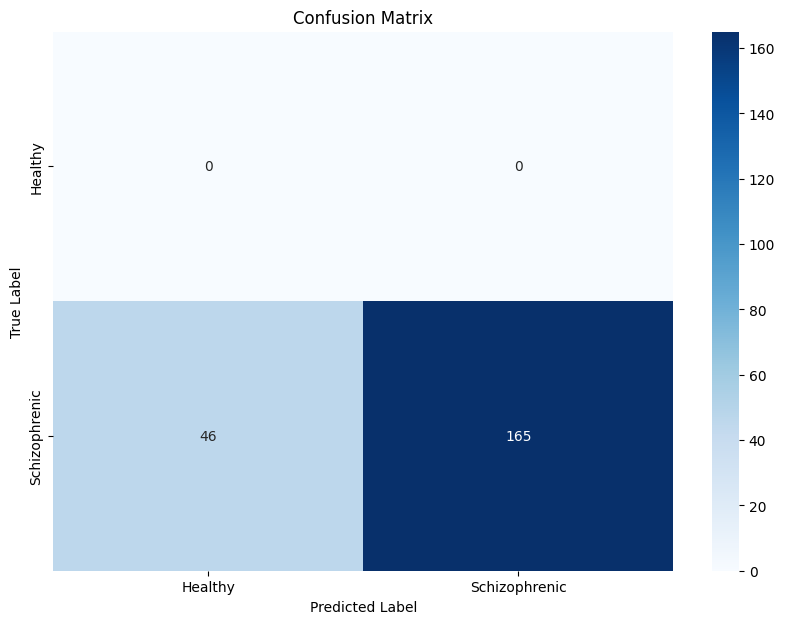




Test group: [15]
Epoch 1/8
28/28 [==============================] - 3s 69ms/step - loss: 0.7204 - accuracy: 0.5245 - val_loss: 0.6444 - val_accuracy: 0.8077
Epoch 2/8
28/28 [==============================] - 2s 66ms/step - loss: 0.6966 - accuracy: 0.5286 - val_loss: 0.6892 - val_accuracy: 0.5350
Epoch 3/8
28/28 [==============================] - 2s 66ms/step - loss: 0.6856 - accuracy: 0.5417 - val_loss: 0.6831 - val_accuracy: 0.5944
Epoch 4/8
28/28 [==============================] - 2s 66ms/step - loss: 0.6807 - accuracy: 0.5498 - val_loss: 0.6854 - val_accuracy: 0.5175
Epoch 5/8
28/28 [==============================] - 2s 63ms/step - loss: 0.6790 - accuracy: 0.5494 - val_loss: 0.6900 - val_accuracy: 0.5175
Epoch 6/8
28/28 [==============================] - 2s 67ms/step - loss: 0.6724 - accuracy: 0.5599 - val_loss: 0.6984 - val_accuracy: 0.4091
Epoch 7/8
28/28 [==============================] - 2s 67ms/step - loss: 0.6613 - accuracy: 0.5803 - val_loss: 0.6966 - val_accuracy: 0.4301


C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


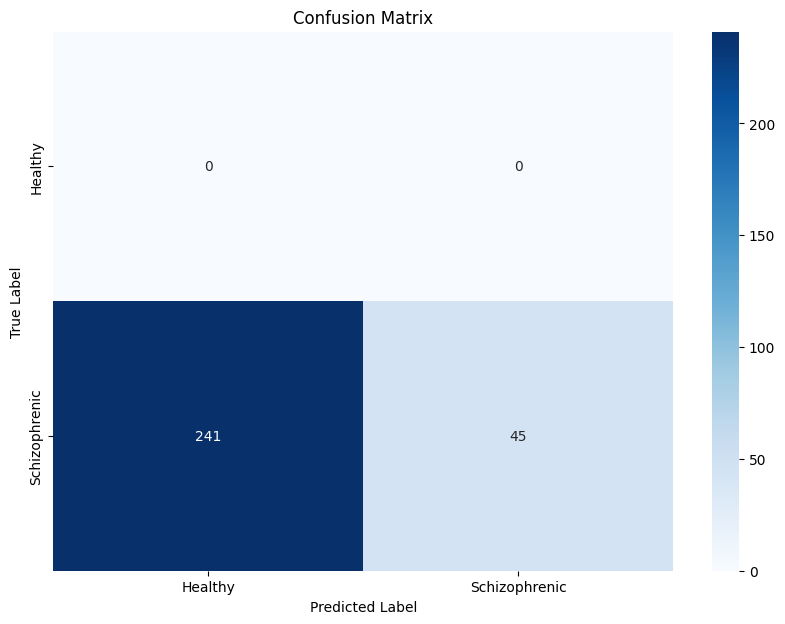




Test group: [16]
Epoch 1/8
28/28 [==============================] - 3s 71ms/step - loss: 0.7068 - accuracy: 0.5192 - val_loss: 0.6419 - val_accuracy: 0.8292
Epoch 2/8
28/28 [==============================] - 2s 66ms/step - loss: 0.6872 - accuracy: 0.5272 - val_loss: 0.6398 - val_accuracy: 0.9042
Epoch 3/8
28/28 [==============================] - 2s 71ms/step - loss: 0.6800 - accuracy: 0.5419 - val_loss: 0.6661 - val_accuracy: 0.7292
Epoch 4/8
28/28 [==============================] - 2s 69ms/step - loss: 0.6711 - accuracy: 0.5534 - val_loss: 0.6597 - val_accuracy: 0.7500
Epoch 5/8
28/28 [==============================] - 2s 66ms/step - loss: 0.6680 - accuracy: 0.5670 - val_loss: 0.7088 - val_accuracy: 0.3292
Epoch 6/8
28/28 [==============================] - 2s 69ms/step - loss: 0.6582 - accuracy: 0.5870 - val_loss: 0.7161 - val_accuracy: 0.2958
Epoch 7/8
28/28 [==============================] - 2s 67ms/step - loss: 0.6516 - accuracy: 0.5942 - val_loss: 0.7734 - val_accuracy: 0.1333


C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


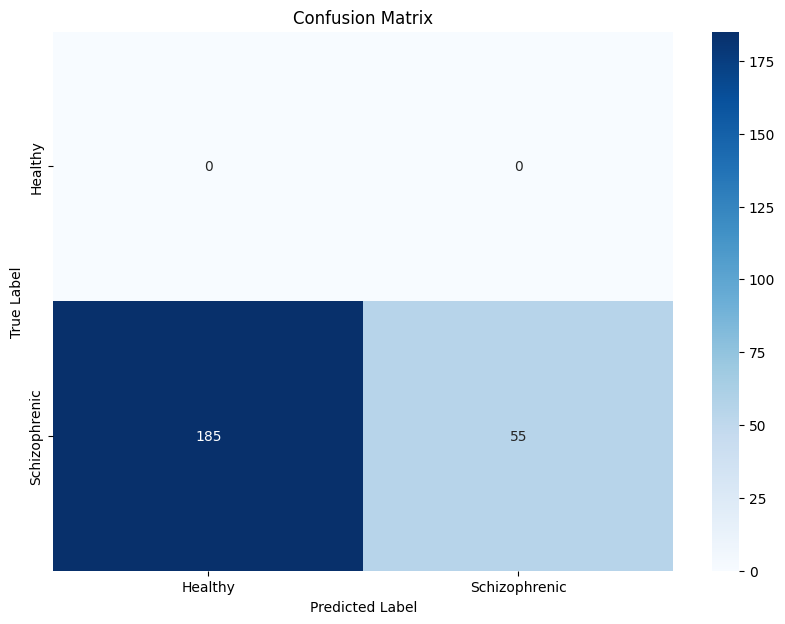




Test group: [17]
Epoch 1/8
27/27 [==============================] - 3s 71ms/step - loss: 0.7420 - accuracy: 0.5142 - val_loss: 0.6538 - val_accuracy: 0.7708
Epoch 2/8
27/27 [==============================] - 2s 70ms/step - loss: 0.7010 - accuracy: 0.5188 - val_loss: 0.6625 - val_accuracy: 0.8173
Epoch 3/8
27/27 [==============================] - 2s 66ms/step - loss: 0.6863 - accuracy: 0.5349 - val_loss: 0.6560 - val_accuracy: 0.9037
Epoch 4/8
27/27 [==============================] - 2s 67ms/step - loss: 0.6835 - accuracy: 0.5445 - val_loss: 0.6691 - val_accuracy: 0.7907
Epoch 5/8
27/27 [==============================] - 2s 70ms/step - loss: 0.6739 - accuracy: 0.5538 - val_loss: 0.6890 - val_accuracy: 0.4551
Epoch 6/8
27/27 [==============================] - 2s 70ms/step - loss: 0.6647 - accuracy: 0.5790 - val_loss: 0.7097 - val_accuracy: 0.2658
Epoch 7/8
27/27 [==============================] - 2s 67ms/step - loss: 0.6560 - accuracy: 0.5961 - val_loss: 0.7862 - val_accuracy: 0.0764


C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


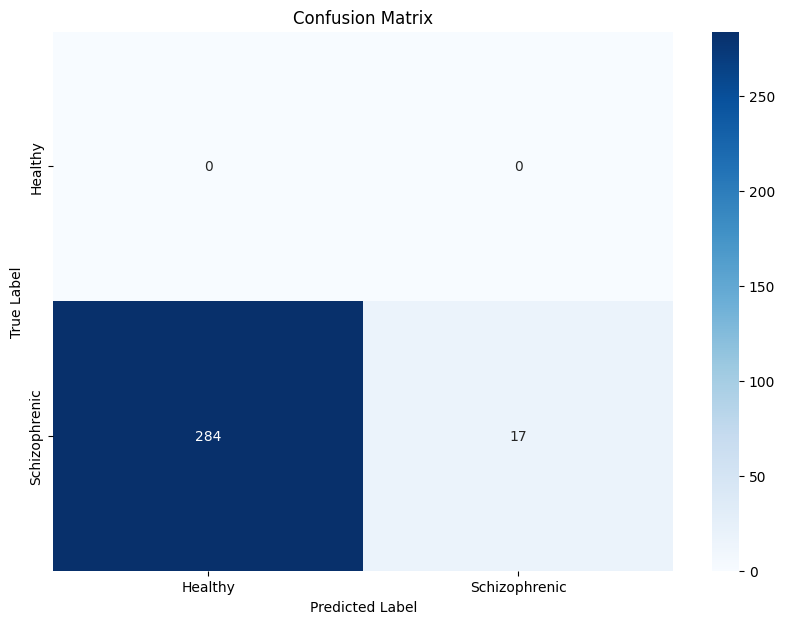




Test group: [18]
Epoch 1/8
28/28 [==============================] - 4s 79ms/step - loss: 0.7566 - accuracy: 0.5144 - val_loss: 0.6047 - val_accuracy: 0.8649
Epoch 2/8
28/28 [==============================] - 2s 70ms/step - loss: 0.7061 - accuracy: 0.5141 - val_loss: 0.5827 - val_accuracy: 0.9730
Epoch 3/8
28/28 [==============================] - 2s 74ms/step - loss: 0.6944 - accuracy: 0.5302 - val_loss: 0.5976 - val_accuracy: 0.9910
Epoch 4/8
28/28 [==============================] - 2s 73ms/step - loss: 0.6912 - accuracy: 0.5402 - val_loss: 0.6154 - val_accuracy: 0.9685
Epoch 5/8
28/28 [==============================] - 2s 81ms/step - loss: 0.6806 - accuracy: 0.5435 - val_loss: 0.6125 - val_accuracy: 0.9595
Epoch 6/8
28/28 [==============================] - 2s 70ms/step - loss: 0.6788 - accuracy: 0.5478 - val_loss: 0.6325 - val_accuracy: 0.8964
Epoch 7/8
28/28 [==============================] - 2s 72ms/step - loss: 0.6765 - accuracy: 0.5508 - val_loss: 0.6399 - val_accuracy: 0.8468


C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


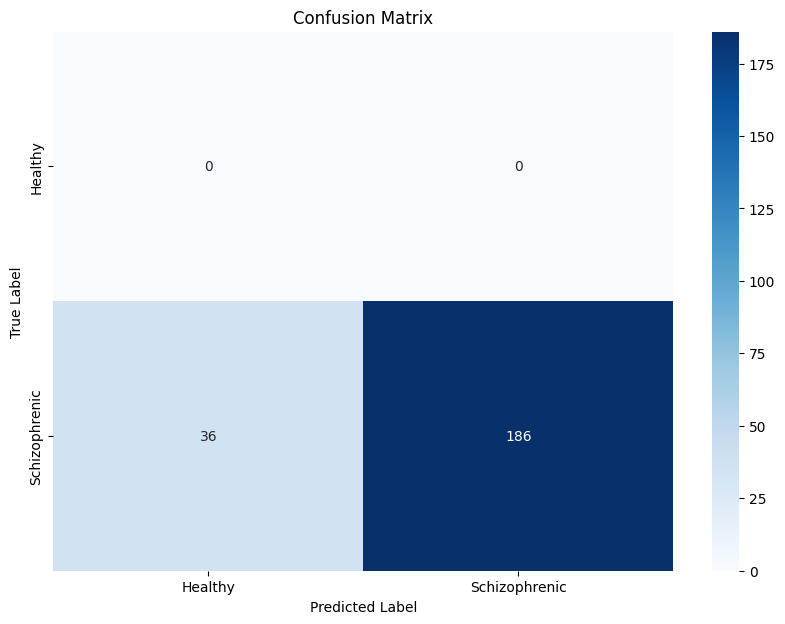




Test group: [19]
Epoch 1/8
28/28 [==============================] - 3s 78ms/step - loss: 0.7355 - accuracy: 0.5223 - val_loss: 0.6265 - val_accuracy: 0.8207
Epoch 2/8
28/28 [==============================] - 2s 68ms/step - loss: 0.6927 - accuracy: 0.5338 - val_loss: 0.6284 - val_accuracy: 0.8967
Epoch 3/8
28/28 [==============================] - 2s 69ms/step - loss: 0.6842 - accuracy: 0.5450 - val_loss: 0.6481 - val_accuracy: 0.9022
Epoch 4/8
28/28 [==============================] - 2s 71ms/step - loss: 0.6812 - accuracy: 0.5464 - val_loss: 0.6542 - val_accuracy: 0.8478
Epoch 5/8
28/28 [==============================] - 2s 68ms/step - loss: 0.6708 - accuracy: 0.5511 - val_loss: 0.6519 - val_accuracy: 0.8533
Epoch 6/8
28/28 [==============================] - 2s 70ms/step - loss: 0.6677 - accuracy: 0.5626 - val_loss: 0.6568 - val_accuracy: 0.7989
Epoch 7/8
28/28 [==============================] - 2s 72ms/step - loss: 0.6625 - accuracy: 0.5729 - val_loss: 0.7139 - val_accuracy: 0.4239


C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


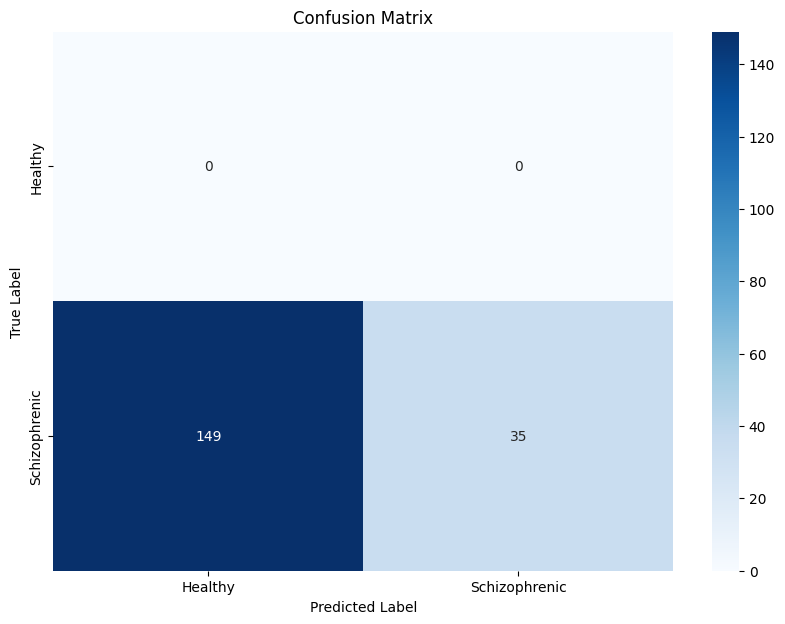




Test group: [20]
Epoch 1/8
27/27 [==============================] - 3s 76ms/step - loss: 0.7287 - accuracy: 0.5235 - val_loss: 0.6340 - val_accuracy: 0.8869
Epoch 2/8
27/27 [==============================] - 2s 70ms/step - loss: 0.6912 - accuracy: 0.5355 - val_loss: 0.6655 - val_accuracy: 0.7173
Epoch 3/8
27/27 [==============================] - 2s 69ms/step - loss: 0.6819 - accuracy: 0.5371 - val_loss: 0.6633 - val_accuracy: 0.7530
Epoch 4/8
27/27 [==============================] - 2s 71ms/step - loss: 0.6783 - accuracy: 0.5546 - val_loss: 0.6732 - val_accuracy: 0.6518
Epoch 5/8
27/27 [==============================] - 2s 72ms/step - loss: 0.6581 - accuracy: 0.5886 - val_loss: 0.7246 - val_accuracy: 0.2351
Epoch 6/8
27/27 [==============================] - 2s 73ms/step - loss: 0.6324 - accuracy: 0.6313 - val_loss: 0.7576 - val_accuracy: 0.2262
Epoch 7/8
27/27 [==============================] - 2s 75ms/step - loss: 0.5959 - accuracy: 0.6916 - val_loss: 0.7499 - val_accuracy: 0.4405


C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


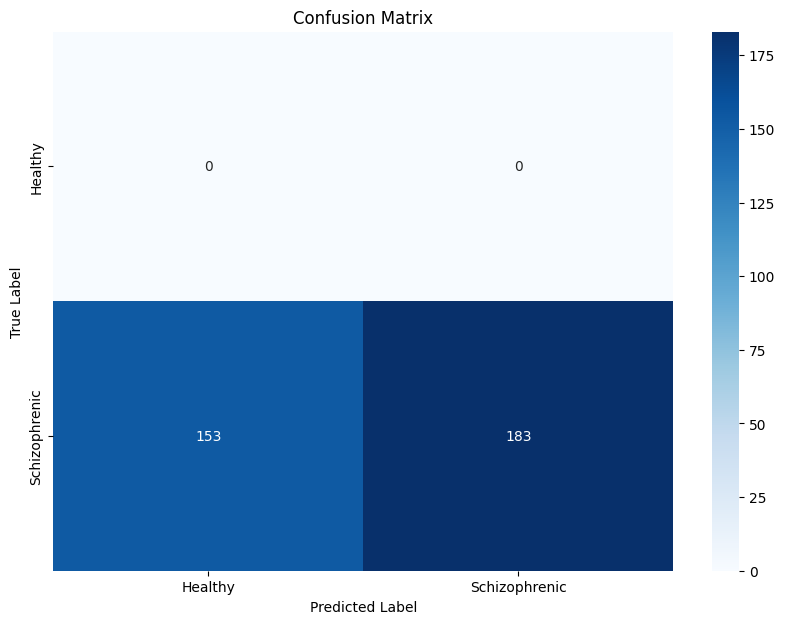




Test group: [21]
Epoch 1/8
28/28 [==============================] - 3s 79ms/step - loss: 0.7359 - accuracy: 0.5082 - val_loss: 0.6275 - val_accuracy: 0.9339
Epoch 2/8
28/28 [==============================] - 2s 73ms/step - loss: 0.6993 - accuracy: 0.5238 - val_loss: 0.6358 - val_accuracy: 0.9736
Epoch 3/8
28/28 [==============================] - 2s 76ms/step - loss: 0.6896 - accuracy: 0.5328 - val_loss: 0.6550 - val_accuracy: 0.9075
Epoch 4/8
28/28 [==============================] - 2s 78ms/step - loss: 0.6867 - accuracy: 0.5384 - val_loss: 0.6591 - val_accuracy: 0.8943
Epoch 5/8
28/28 [==============================] - 2s 78ms/step - loss: 0.6775 - accuracy: 0.5488 - val_loss: 0.6532 - val_accuracy: 0.9515
Epoch 6/8
28/28 [==============================] - 2s 71ms/step - loss: 0.6781 - accuracy: 0.5559 - val_loss: 0.6770 - val_accuracy: 0.6960
Epoch 7/8
28/28 [==============================] - 2s 74ms/step - loss: 0.6706 - accuracy: 0.5597 - val_loss: 0.6860 - val_accuracy: 0.5683


C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


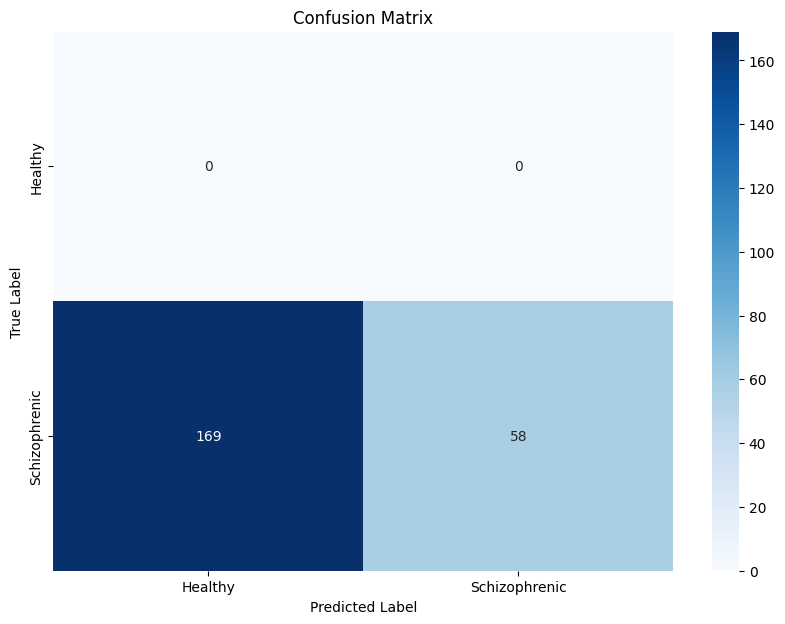




Test group: [22]
Epoch 1/8
27/27 [==============================] - 3s 74ms/step - loss: 0.7912 - accuracy: 0.5153 - val_loss: 0.6319 - val_accuracy: 0.8243
Epoch 2/8
27/27 [==============================] - 2s 68ms/step - loss: 0.7050 - accuracy: 0.5182 - val_loss: 0.6134 - val_accuracy: 0.9696
Epoch 3/8
27/27 [==============================] - 2s 66ms/step - loss: 0.6977 - accuracy: 0.5189 - val_loss: 0.6171 - val_accuracy: 0.9932
Epoch 4/8
27/27 [==============================] - 2s 71ms/step - loss: 0.6910 - accuracy: 0.5351 - val_loss: 0.6248 - val_accuracy: 1.0000
Epoch 5/8
27/27 [==============================] - 2s 73ms/step - loss: 0.6899 - accuracy: 0.5272 - val_loss: 0.6237 - val_accuracy: 0.9966
Epoch 6/8
27/27 [==============================] - 2s 74ms/step - loss: 0.6860 - accuracy: 0.5301 - val_loss: 0.6259 - val_accuracy: 0.9966
Epoch 7/8
27/27 [==============================] - 2s 78ms/step - loss: 0.6818 - accuracy: 0.5325 - val_loss: 0.6305 - val_accuracy: 1.0000


C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


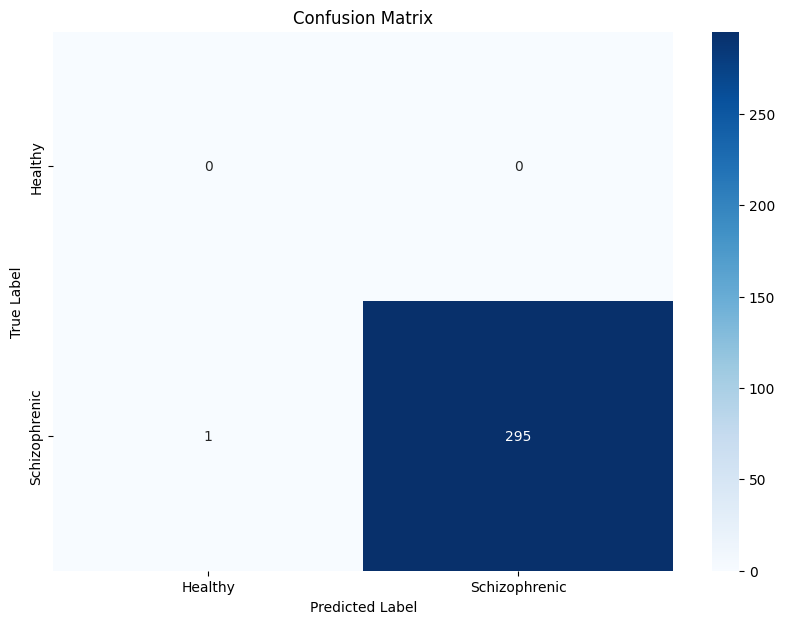




Test group: [23]
Epoch 1/8
28/28 [==============================] - 3s 77ms/step - loss: 0.7287 - accuracy: 0.5178 - val_loss: 0.6517 - val_accuracy: 0.8538
Epoch 2/8
28/28 [==============================] - 2s 65ms/step - loss: 0.6891 - accuracy: 0.5441 - val_loss: 0.6691 - val_accuracy: 0.7689
Epoch 3/8
28/28 [==============================] - 2s 73ms/step - loss: 0.6759 - accuracy: 0.5572 - val_loss: 0.6719 - val_accuracy: 0.7358
Epoch 4/8
28/28 [==============================] - 2s 74ms/step - loss: 0.6686 - accuracy: 0.5752 - val_loss: 0.6947 - val_accuracy: 0.5000
Epoch 5/8
28/28 [==============================] - 2s 72ms/step - loss: 0.6425 - accuracy: 0.6072 - val_loss: 0.7072 - val_accuracy: 0.4104
Epoch 6/8
28/28 [==============================] - 2s 74ms/step - loss: 0.5986 - accuracy: 0.6815 - val_loss: 0.7486 - val_accuracy: 0.2217
Epoch 7/8
28/28 [==============================] - 2s 66ms/step - loss: 0.5495 - accuracy: 0.7299 - val_loss: 0.9760 - val_accuracy: 0.0047


C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


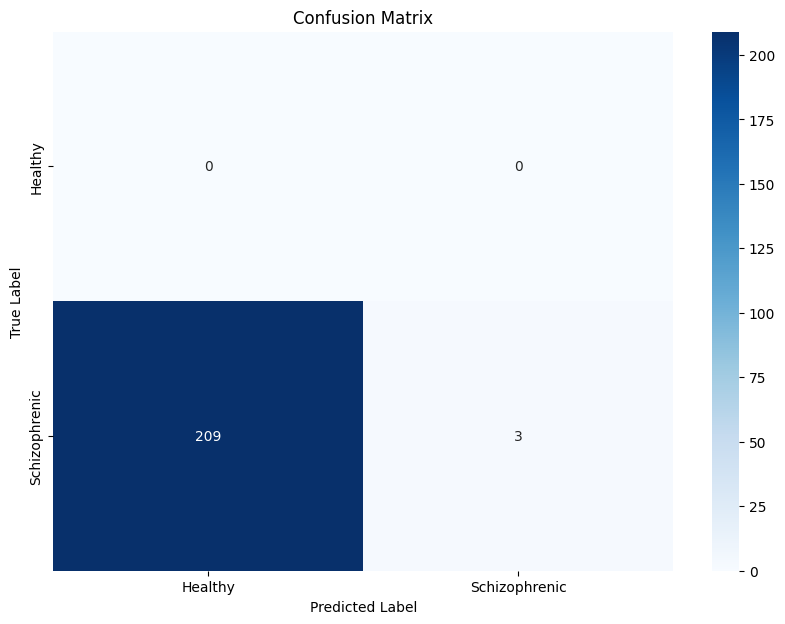




Test group: [24]
Epoch 1/8
27/27 [==============================] - 3s 76ms/step - loss: 0.7289 - accuracy: 0.5080 - val_loss: 0.6687 - val_accuracy: 0.7404
Epoch 2/8
27/27 [==============================] - 2s 71ms/step - loss: 0.7040 - accuracy: 0.5233 - val_loss: 0.6513 - val_accuracy: 0.8584
Epoch 3/8
27/27 [==============================] - 2s 73ms/step - loss: 0.6921 - accuracy: 0.5321 - val_loss: 0.6429 - val_accuracy: 0.8879
Epoch 4/8
27/27 [==============================] - 2s 73ms/step - loss: 0.6869 - accuracy: 0.5436 - val_loss: 0.6298 - val_accuracy: 0.9322
Epoch 5/8
27/27 [==============================] - 2s 73ms/step - loss: 0.6748 - accuracy: 0.5618 - val_loss: 0.6656 - val_accuracy: 0.7109
Epoch 6/8
27/27 [==============================] - 2s 73ms/step - loss: 0.6624 - accuracy: 0.5831 - val_loss: 0.6602 - val_accuracy: 0.6844
Epoch 7/8
27/27 [==============================] - 2s 73ms/step - loss: 0.6397 - accuracy: 0.6212 - val_loss: 0.6504 - val_accuracy: 0.6431


C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


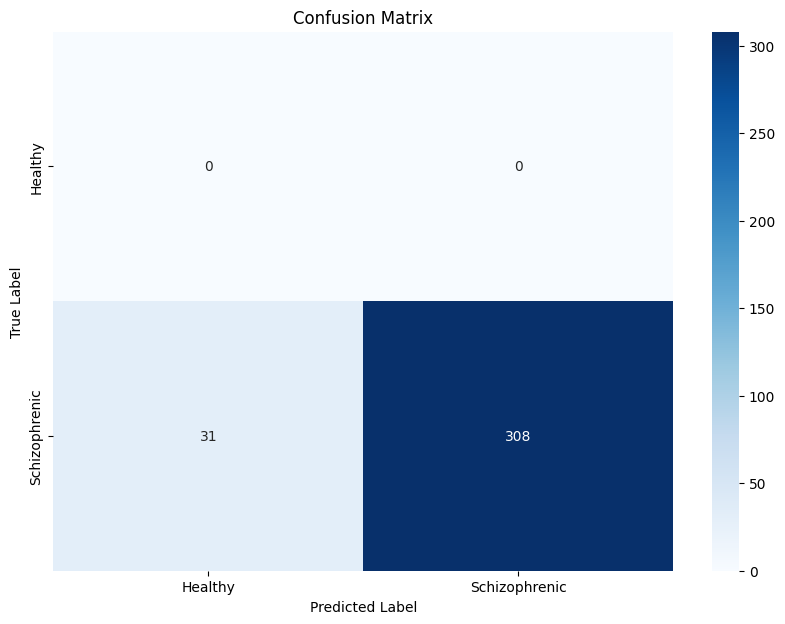




Test group: [25]
Epoch 1/8
28/28 [==============================] - 3s 72ms/step - loss: 0.7550 - accuracy: 0.5201 - val_loss: 0.6659 - val_accuracy: 0.5387
Epoch 2/8
28/28 [==============================] - 2s 67ms/step - loss: 0.7120 - accuracy: 0.5186 - val_loss: 0.6519 - val_accuracy: 0.6531
Epoch 3/8
28/28 [==============================] - 2s 70ms/step - loss: 0.6917 - accuracy: 0.5293 - val_loss: 0.6437 - val_accuracy: 0.7565
Epoch 4/8
28/28 [==============================] - 2s 69ms/step - loss: 0.6955 - accuracy: 0.5355 - val_loss: 0.6582 - val_accuracy: 0.7712
Epoch 5/8
28/28 [==============================] - 2s 68ms/step - loss: 0.6844 - accuracy: 0.5420 - val_loss: 0.6467 - val_accuracy: 0.7786
Epoch 6/8
28/28 [==============================] - 2s 66ms/step - loss: 0.6829 - accuracy: 0.5506 - val_loss: 0.6379 - val_accuracy: 0.7565
Epoch 7/8
28/28 [==============================] - 2s 71ms/step - loss: 0.6691 - accuracy: 0.5672 - val_loss: 0.6494 - val_accuracy: 0.6162


C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


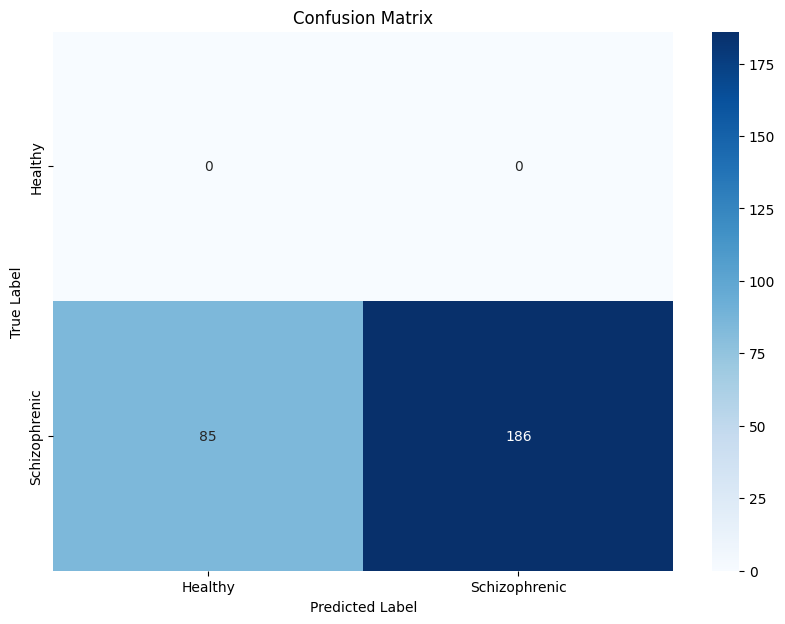




Test group: [26]
Epoch 1/8
28/28 [==============================] - 4s 75ms/step - loss: 0.7373 - accuracy: 0.5114 - val_loss: 0.6627 - val_accuracy: 0.7597
Epoch 2/8
28/28 [==============================] - 2s 69ms/step - loss: 0.6950 - accuracy: 0.5325 - val_loss: 0.6476 - val_accuracy: 0.8905
Epoch 3/8
28/28 [==============================] - 2s 70ms/step - loss: 0.6906 - accuracy: 0.5291 - val_loss: 0.6393 - val_accuracy: 0.9505
Epoch 4/8
28/28 [==============================] - 2s 69ms/step - loss: 0.6888 - accuracy: 0.5296 - val_loss: 0.6597 - val_accuracy: 0.8869
Epoch 5/8
28/28 [==============================] - 2s 85ms/step - loss: 0.6844 - accuracy: 0.5328 - val_loss: 0.6495 - val_accuracy: 0.9541
Epoch 6/8
28/28 [==============================] - 2s 78ms/step - loss: 0.6830 - accuracy: 0.5360 - val_loss: 0.6606 - val_accuracy: 0.9081
Epoch 7/8
28/28 [==============================] - 2s 74ms/step - loss: 0.6795 - accuracy: 0.5419 - val_loss: 0.6605 - val_accuracy: 0.9011


C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


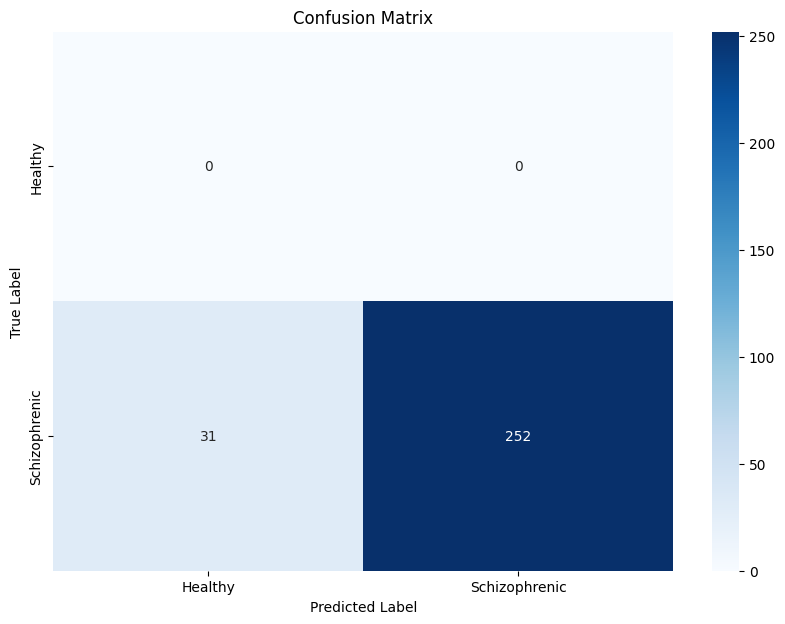




Test group: [27]
Epoch 1/8
27/27 [==============================] - 3s 78ms/step - loss: 0.7782 - accuracy: 0.5065 - val_loss: 0.6551 - val_accuracy: 0.6181
Epoch 2/8
27/27 [==============================] - 2s 69ms/step - loss: 0.7129 - accuracy: 0.4989 - val_loss: 0.6753 - val_accuracy: 0.6199
Epoch 3/8
27/27 [==============================] - 2s 72ms/step - loss: 0.6986 - accuracy: 0.5184 - val_loss: 0.6454 - val_accuracy: 0.8395
Epoch 4/8
27/27 [==============================] - 2s 69ms/step - loss: 0.7019 - accuracy: 0.5118 - val_loss: 0.6341 - val_accuracy: 0.8708
Epoch 5/8
27/27 [==============================] - 2s 72ms/step - loss: 0.6954 - accuracy: 0.5219 - val_loss: 0.6256 - val_accuracy: 0.9299
Epoch 6/8
27/27 [==============================] - 2s 69ms/step - loss: 0.6923 - accuracy: 0.5289 - val_loss: 0.6344 - val_accuracy: 0.8985
Epoch 7/8
27/27 [==============================] - 2s 72ms/step - loss: 0.6939 - accuracy: 0.5225 - val_loss: 0.6456 - val_accuracy: 0.8450


C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


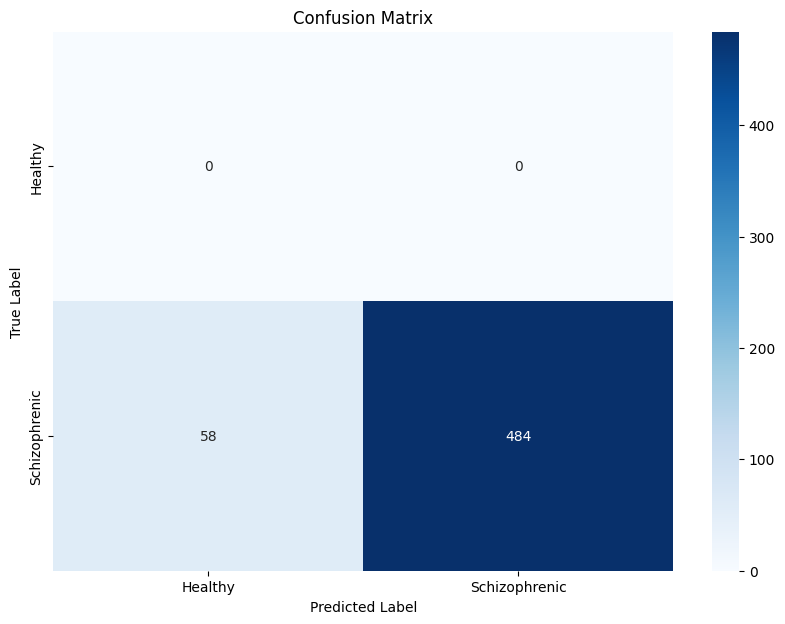

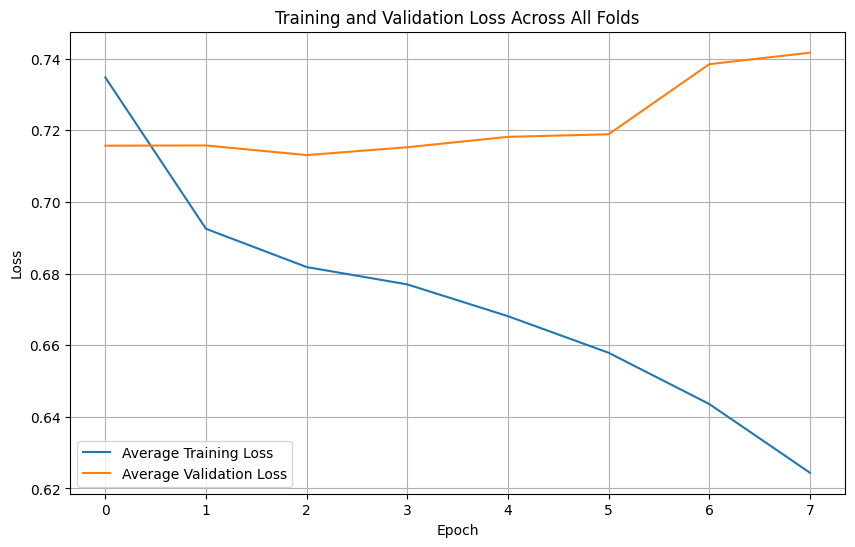

In [206]:
#gkf=GroupKFold(n_splits=4)
logo = LeaveOneGroupOut()

K.clear_session()

# Initialize lists to store metrics for each fold
accuracies = []
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []
confusion_matrices = []

#shuffled_groups = shuffle_group_labels(one_d_cnn_group_array)

for train_index, val_index in logo.split(one_d_cnn_data_array, one_d_cnn_label_array, groups=one_d_cnn_group_array):
    print("\n\n")

    print("Test group:", np.unique(one_d_cnn_group_array[val_index]))
    train_features,train_labels=one_d_cnn_data_array[train_index],one_d_cnn_label_array[train_index]
    val_features,val_labels=one_d_cnn_data_array[val_index],one_d_cnn_label_array[val_index]
    
    scaler=StandardScaler()

    train_features = scaler.fit_transform(train_features.reshape(-1, train_features.shape[-1])).reshape(train_features.shape)
    val_features = scaler.transform(val_features.reshape(-1, val_features.shape[-1])).reshape(val_features.shape)
    
    K.clear_session()
    model=cnnmodel()
    
    history = model.fit(train_features,train_labels,
              epochs=8,
              batch_size=256,
              validation_data=(val_features,val_labels)
             )
    
    # Append loss and accuracy from the training history
    training_losses.append(history.history['loss'])
    validation_losses.append(history.history['val_loss'])
    training_accuracies.append(history.history['accuracy'])
    validation_accuracies.append(history.history['val_accuracy'])


    # Generate and store confusion matrix for the fold
    raw_predictions = model.predict(val_features)
    predictions = (raw_predictions > 0.5).astype(int)
    cm = confusion_matrix(val_labels, predictions)

    confusion_matrices.append(cm)
    print(classification_report(val_labels, predictions))

    
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Schizophrenic'], yticklabels=['Healthy', 'Schizophrenic'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()




mean_training_losses = np.mean(training_losses,axis=0)
mean_validation_losses = np.mean(validation_losses,axis=0)
mean_training_accuracies = np.mean(training_accuracies,axis=0)
mean_validation_accuracies = np.mean(validation_accuracies,axis=0)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(mean_training_losses, label='Average Training Loss')
plt.plot(mean_validation_losses, label='Average Validation Loss')
plt.title('Training and Validation Loss Across All Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Badly classified:

labels : 0,9,13,16,21,24

#### Optimizing Evaluation

We will change the way we are classifying patients based on a majority vote for each epoch (stimuli):

Explanation:

Predictions: Each epoch within a group is predicted, and then the mean of these predictions determines the group's classification.

Thresholding: If the mean prediction exceeds 0.5, the group is classified as schizophrenic; otherwise, it is classified as healthy.

Metrics Calculation: The predictions for each patient are used to update the confusion matrix and other metrics.

This approach evaluates the model based on its ability to classify patients correctly, not just individual epochs, aligning more closely with clinical diagnostic processes.

In [22]:
model=cnnmodel()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 622, 10)           1530      
                                                                 
 batch_normalization (Batch  (None, 622, 10)           40        
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 622, 10)           0         
                                                                 
 average_pooling1d (Average  (None, 311, 10)           0         
 Pooling1D)                                                      
                                                                 
 dropout (Dropout)           (None, 311, 10)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 307, 5)            2




Test group: [0]
Epoch 1/5
55/55 [==============================] - 5s 69ms/step - loss: 0.7002 - accuracy: 0.5461 - val_loss: 0.7761 - val_accuracy: 0.0606
Epoch 2/5
55/55 [==============================] - 4s 66ms/step - loss: 0.6536 - accuracy: 0.5960 - val_loss: 0.6619 - val_accuracy: 0.6883
Epoch 3/5
55/55 [==============================] - 4s 68ms/step - loss: 0.5937 - accuracy: 0.6782 - val_loss: 0.3713 - val_accuracy: 1.0000
Epoch 4/5
55/55 [==============================] - 4s 66ms/step - loss: 0.5028 - accuracy: 0.7673 - val_loss: 0.1999 - val_accuracy: 1.0000
Epoch 5/5
55/55 [==============================] - 4s 66ms/step - loss: 0.4379 - accuracy: 0.8075 - val_loss: 0.5007 - val_accuracy: 0.8139
[0.7761349081993103, 0.6618885397911072, 0.3712555170059204, 0.19988031685352325, 0.500708818435669]
8/8 [==============================] - 0s 5ms/step
Averaged Prediction: : 0.3771869
Correctly Identified:  True


C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved improved model with validation loss: 0.500708818435669



Test group: [1]
Epoch 1/5
55/55 [==============================] - 5s 70ms/step - loss: 0.6869 - accuracy: 0.5548 - val_loss: 0.6503 - val_accuracy: 0.7820
Epoch 2/5
55/55 [==============================] - 4s 68ms/step - loss: 0.6057 - accuracy: 0.6742 - val_loss: 0.7607 - val_accuracy: 0.3555
Epoch 3/5
55/55 [==============================] - 4s 67ms/step - loss: 0.4717 - accuracy: 0.7986 - val_loss: 0.5688 - val_accuracy: 0.7488
Epoch 4/5
55/55 [==============================] - 4s 68ms/step - loss: 0.4028 - accuracy: 0.8338 - val_loss: 0.4966 - val_accuracy: 0.8578
Epoch 5/5
55/55 [==============================] - 4s 66ms/step - loss: 0.3476 - accuracy: 0.8614 - val_loss: 0.3563 - val_accuracy: 0.9621
[0.6503420472145081, 0.760749101638794, 0.5687851309776306, 0.4966140389442444, 0.3562553822994232]
7/7 [==============================] - 0s 5ms/step
Averaged Prediction: : 0.7114796
Correctly Identified:  True
Saved im

C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/5
55/55 [==============================] - 6s 83ms/step - loss: 0.6872 - accuracy: 0.5561 - val_loss: 0.7540 - val_accuracy: 0.0396
Epoch 2/5
55/55 [==============================] - 4s 72ms/step - loss: 0.6299 - accuracy: 0.6217 - val_loss: 0.6690 - val_accuracy: 0.6520
Epoch 3/5
55/55 [==============================] - 4s 65ms/step - loss: 0.5362 - accuracy: 0.7409 - val_loss: 0.4110 - val_accuracy: 0.9692
Epoch 4/5
55/55 [==============================] - 4s 67ms/step - loss: 0.4648 - accuracy: 0.7852 - val_loss: 0.7378 - val_accuracy: 0.4846
Epoch 5/5
55/55 [==============================] - 4s 68ms/step - loss: 0.4178 - accuracy: 0.8157 - val_loss: 1.3891 - val_accuracy: 0.1145
[0.7540331482887268, 0.669026792049408, 0.41104012727737427, 0.7377676367759705, 1.3891265392303467]
8/8 [==============================] - 0s 5ms/step
Averaged Prediction: : 0.71377915
Correctly Identified:  False



Test group: [3]
Epoch 1/5
55/55 [==============================] - 5s 67ms/step - 

C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/5
55/55 [==============================] - 5s 64ms/step - loss: 0.6968 - accuracy: 0.5580 - val_loss: 0.7423 - val_accuracy: 0.0823
Epoch 2/5
55/55 [==============================] - 4s 65ms/step - loss: 0.6478 - accuracy: 0.6023 - val_loss: 0.6370 - val_accuracy: 0.7879
Epoch 3/5
55/55 [==============================] - 4s 66ms/step - loss: 0.6075 - accuracy: 0.6580 - val_loss: 0.4719 - val_accuracy: 0.9610
Epoch 4/5
55/55 [==============================] - 4s 66ms/step - loss: 0.5300 - accuracy: 0.7321 - val_loss: 0.5138 - val_accuracy: 0.8831
Epoch 5/5
55/55 [==============================] - 4s 65ms/step - loss: 0.4568 - accuracy: 0.7938 - val_loss: 0.3227 - val_accuracy: 0.9697
[0.7422696948051453, 0.6370033621788025, 0.47186556458473206, 0.5137940645217896, 0.32270514965057373]
8/8 [==============================] - 0s 5ms/step
Averaged Prediction: : 0.256313
Correctly Identified:  True



Test group: [7]
Epoch 1/5
54/54 [==============================] - 5s 71ms/step - l

C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved improved model with validation loss: 0.18405446410179138



Test group: [18]
Epoch 1/5
55/55 [==============================] - 5s 63ms/step - loss: 0.6620 - accuracy: 0.5836 - val_loss: 1.3026 - val_accuracy: 0.0144
Epoch 2/5
55/55 [==============================] - 3s 61ms/step - loss: 0.5467 - accuracy: 0.7191 - val_loss: 2.4754 - val_accuracy: 0.0288
Epoch 3/5
55/55 [==============================] - 3s 61ms/step - loss: 0.4440 - accuracy: 0.8111 - val_loss: 3.2214 - val_accuracy: 0.0252
Epoch 4/5
55/55 [==============================] - 3s 61ms/step - loss: 0.3803 - accuracy: 0.8475 - val_loss: 2.7141 - val_accuracy: 0.0827
Epoch 5/5
55/55 [==============================] - 3s 60ms/step - loss: 0.3454 - accuracy: 0.8665 - val_loss: 3.3928 - val_accuracy: 0.0180
[1.3025648593902588, 2.4753918647766113, 3.2214345932006836, 2.714055299758911, 3.392817258834839]
9/9 [==============================] - 0s 5ms/step
Averaged Prediction: : 0.8210342
Correctly Identified:  False



Te

C:\ProgramData\anaconda3\envs\eeg\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved improved model with validation loss: 0.02828993834555149



Test group: [24]
Epoch 1/5
55/55 [==============================] - 5s 65ms/step - loss: 0.6913 - accuracy: 0.5652 - val_loss: 0.7566 - val_accuracy: 0.0332
Epoch 2/5
55/55 [==============================] - 3s 63ms/step - loss: 0.5992 - accuracy: 0.6779 - val_loss: 0.5175 - val_accuracy: 0.9751
Epoch 3/5
55/55 [==============================] - 3s 63ms/step - loss: 0.4548 - accuracy: 0.7937 - val_loss: 0.4555 - val_accuracy: 0.9502
Epoch 4/5
55/55 [==============================] - 3s 63ms/step - loss: 0.3756 - accuracy: 0.8407 - val_loss: 0.4721 - val_accuracy: 0.9170
Epoch 5/5
55/55 [==============================] - 3s 62ms/step - loss: 0.3458 - accuracy: 0.8566 - val_loss: 0.6369 - val_accuracy: 0.7095
[0.7565824389457703, 0.5174919366836548, 0.45546334981918335, 0.47208958864212036, 0.6369425058364868]
8/8 [==============================] - 0s 5ms/step
Averaged Prediction: : 0.4505912
Correctly Identified:  True




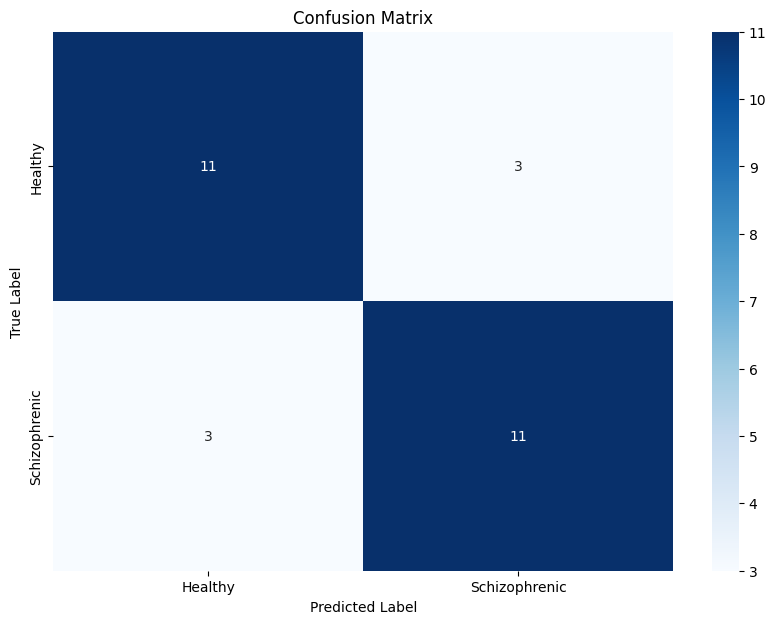

              precision    recall  f1-score   support

       False       0.79      0.79      0.79        14
        True       0.79      0.79      0.79        14

    accuracy                           0.79        28
   macro avg       0.79      0.79      0.79        28
weighted avg       0.79      0.79      0.79        28



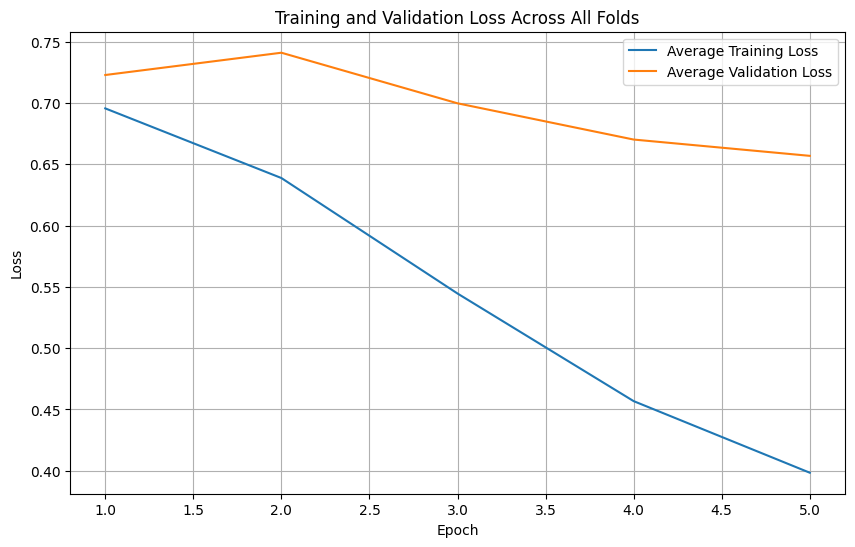

In [80]:
best_loss = float('inf')
best_model_path = 'best_1D_CNN_model.h5'

best_model_weights = None
best_fold_info = None


#gkf=GroupKFold(n_splits=4)
logo = LeaveOneGroupOut()

# Initialize lists to store metrics for each fold
accuracies = []
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []
confusion_matrices = []

group_predictions = []
actual_group_labels = []
#shuffled_groups = shuffle_group_labels(one_d_cnn_group_array)

for train_index, val_index in logo.split(one_d_cnn_data_array, one_d_cnn_label_array, groups=one_d_cnn_group_array):
    print("\n\n")

    print("Test group:", np.unique(one_d_cnn_group_array[val_index]))
    train_features,train_labels=one_d_cnn_data_array[train_index],one_d_cnn_label_array[train_index]
    val_features,val_labels=one_d_cnn_data_array[val_index],one_d_cnn_label_array[val_index]

    #print(train_labels[0:128])
    #paired_data = list(zip(train_features, train_labels))
    #random.shuffle(paired_data)
    #train_features, train_labels = zip(*paired_data)

    #train_features = np.array(train_features)
    #train_labels = np.array(train_labels)

    #print(train_labels[0:128])

    
    scaler=StandardScaler()

    train_features = scaler.fit_transform(train_features.reshape(-1, train_features.shape[-1])).reshape(train_features.shape)
    val_features = scaler.transform(val_features.reshape(-1, val_features.shape[-1])).reshape(val_features.shape)
    
    K.clear_session()
    model=cnnmodel()
    
    # Setup ReduceLROnPlateau callback
    #reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=2, min_lr=0.00001, verbose=2)
    
    history = model.fit(train_features,train_labels,
              epochs=5,
              batch_size=128,
              shuffle=True,
              validation_data=(val_features,val_labels)
             )
    
    # Append loss and accuracy from the training history

    print(history.history['val_loss'])
    training_losses.append(history.history['loss'])
    validation_losses.append(history.history['val_loss'])
    training_accuracies.append(history.history['accuracy'])
    validation_accuracies.append(history.history['val_accuracy'])

    raw_predictions = model.predict(val_features)
    
    group_prediction = np.mean(raw_predictions) > 0.6
    print("Averaged Prediction: :", np.mean(raw_predictions))
    #print("sample of predictions: :", raw_predictions[0:10])
    actual_group_label = np.mean(val_labels) > 0.5

    group_predictions.append(group_prediction)  # True if average prediction > 0.5, False otherwise
    actual_group_labels.append(actual_group_label)  # Assumes all labels in the group are the same

    accuracies.append(((group_prediction == actual_group_label)*1).astype(int))
    print("Correctly Identified: ",  group_prediction == actual_group_label)


    if history.history['val_loss'][-1] < best_loss:
        best_loss = history.history['val_loss'][-1]
        # Save the model
        model.save(best_model_path)
        print(f"Saved improved model with validation loss: {history.history['val_loss'][-1]}")

mean_training_losses = np.mean(training_losses,axis=0)
mean_validation_losses = np.mean(validation_losses,axis=0)
mean_training_accuracies = np.mean(training_accuracies,axis=0)
mean_validation_accuracies = np.mean(validation_accuracies,axis=0)

print("Final Validation Accuracy: ", np.mean(accuracies))
      
# Generate and store confusion matrix for the fold

final_cm = confusion_matrix(actual_group_labels, group_predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(final_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Healthy', 'Schizophrenic'], yticklabels=['Healthy', 'Schizophrenic'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(classification_report(actual_group_labels, group_predictions))
ep = range(1,6)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(ep,mean_training_losses, label='Average Training Loss')
plt.plot(ep,mean_validation_losses,label='Average Validation Loss')
plt.title('Training and Validation Loss Across All Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
